# ANFIS classifier
***
A three label classifier for market behavior prediction based on Jang's original ANFIS architecture

## LUISS 'Guido Carli' - A.Y. 2023-24  
Machine Learning Project Submission

Marchioni Gian Lorenzo - Paquette David - Tomasella Elena
***

In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

import utilities
# utilities.py file contains functions for calculations and plots

import sys
#sys.path.append(r'C:\Users\Gian\OneDrive - LUISS Libera Università Internazionale degli Studi Sociali Guido Carli\ML\Final Project\anfis_gian')

import anfis
import membership 
import experimental
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import nolds

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, confusion_matrix

In [2]:
msft = pd.read_csv(#r'C:\Users\Gian\OneDrive - LUISS Libera Università Internazionale degli Studi Sociali Guido Carli\ML\Final Project\Weekly series\Microsoft_weekly_ok.csv', 
                   index_col=False, 
                   parse_dates=['Date'])
amzn = pd.read_csv(#r'C:\Users\Gian\OneDrive - LUISS Libera Università Internazionale degli Studi Sociali Guido Carli\ML\Final Project\Weekly series\Amazon_weekly_ok.csv', 
                   index_col=False, 
                   parse_dates=['Date'])
ibm = pd.read_csv(#r'C:\Users\Gian\OneDrive - LUISS Libera Università Internazionale degli Studi Sociali Guido Carli\ML\Final Project\Weekly series\IBM_weekly_ok.csv', 
                  index_col=False, 
                  parse_dates=['Date'])
cac = pd.read_csv(#r'C:\Users\Gian\OneDrive - LUISS Libera Università Internazionale degli Studi Sociali Guido Carli\ML\Final Project\Weekly series\Cac_weekly_ok.csv', 
                  index_col=False, 
                  parse_dates=['Date'])
sp500 = pd.read_csv(#r'C:\Users\Gian\OneDrive - LUISS Libera Università Internazionale degli Studi Sociali Guido Carli\ML\Final Project\Weekly series\Sp500_weekly_ok.csv', 
                    index_col=False, 
                    parse_dates=['Date'])
nasdaq = pd.read_csv(#r'C:\Users\Gian\OneDrive - LUISS Libera Università Internazionale degli Studi Sociali Guido Carli\ML\Final Project\Weekly series\Nasdaq_weekly_ok.csv', 
                     index_col=False, 
                     parse_dates=['Date'])

In [3]:
dfs = [amzn, cac, ibm, msft, nasdaq, sp500]

for df in dfs:
    # Verify dates are datetime
    df['Date'] = pd.to_datetime(df['Date'])
    # Verify dates are sorted
    df.sort_values('Date', inplace=True)

    df_name =[x for x in globals() if globals()[x] is df][0]
    print(f'Indicator parameters for {df_name}:')

    # Perform Grid Search to look for indicator parameters that maximize Hurst Exponent
    hurst_results_df=utilities.grid_search_hurst(df)
    print(hurst_results_df)
    print('─' * 77)
    
    # Access parameters for the indicators from the hurst_results_df
    rsi_period = hurst_results_df.loc[hurst_results_df['Indicator'] == 'RSI', 'Best Period'].values[0]
    cci_period = hurst_results_df.loc[hurst_results_df['Indicator'] == 'CCI', 'Best Period'].values[0]
    ema_short_period = hurst_results_df.loc[hurst_results_df['Indicator'] == 'EMADN', 'Best Short Period'].values[0]
    ema_long_period = hurst_results_df.loc[hurst_results_df['Indicator'] == 'EMADN', 'Best Long Period'].values[0]
    cpc_window = hurst_results_df.loc[hurst_results_df['Indicator'] == 'CPC', 'Best Period'].values[0]
        
    # Now use these values to calculate the indicators
    # Note that 'Best Short Period'  and  'Best Long Period' only applies for EMADN,
    # as it is the difference between two EMAs. 
    # The other indicators just have one parameter.
    df=utilities.calculate_indicators(df, 
                         rsi_period=rsi_period,
                         cci_period=cci_period, 
                         ema_short_period=ema_short_period, 
                         ema_long_period=ema_long_period, 
                         cpc_window=cpc_window)

    # Compute the weekly returns
    # Assign to each week the next one's return and convert it into the target variable (+1, 0, -1)
    # Target will be the categorical 'Next_week_market_behavior'
    df=utilities.preprocess_market_behavior(df)    

Indicator parameters for amzn:
  Indicator  Best Period  Hurst Exponent  Best Short Period  Best Long Period
0       CCI           36            0.90               <NA>              <NA>
1     EMADN         <NA>            0.92                 24                52
2       CPC           39            0.99               <NA>              <NA>
3       RSI           38            0.96               <NA>              <NA>
─────────────────────────────────────────────────────────────────────────────
Indicator parameters for cac:
  Indicator  Best Period  Hurst Exponent  Best Short Period  Best Long Period
0       CCI           38            0.91               <NA>              <NA>
1     EMADN         <NA>            0.94                 24                58
2       CPC           37            1.01               <NA>              <NA>
3       RSI           37            0.97               <NA>              <NA>
─────────────────────────────────────────────────────────────────────────────
Ind

Target variable is Market Behavior:
- Bullish (upcoming week’s close is higher than the current week’s close): Assign +1.  
- Bearish (upcoming week’s close is lower than the current week’s close): Assign -1.  
- Flat (upcoming week’s close is approximately, according to a threshold, equal to the current week’s close): Assign 0.

In [4]:
amzn.head(5)

Date      Open      High       Low     Close        RSI        CCI  \
0 1998-09-27  0.633333  0.973958  0.633333  0.910420  63.689204  73.116444   
1 1998-10-04  0.969792  1.000000  0.833333  0.918750  64.744361  86.670801   
2 1998-10-11  0.907292  0.935417  0.666667  0.759895  60.301088  48.334561   
3 1998-10-18  0.809375  0.849479  0.747917  0.828645  61.244236  49.218548   
4 1998-10-25  0.825000  0.985938  0.825000  0.967710  63.245437  72.667787   

      EMADN  CPC  Current_week_pct_change  Next_week_pct_change  \
0  0.338982  1.0                37.098025              0.914962   
1  0.333435  1.0                 0.914962            -17.290340   
2  0.318557  1.0               -17.290340              9.047303   
3  0.308201  1.0                 9.047303             16.782217   
4  0.305449  1.0                16.782217              8.880243   

   Next_week_market_behavior  
0                          1  
1                         -1  
2                          1  
3                          1  
4                          1

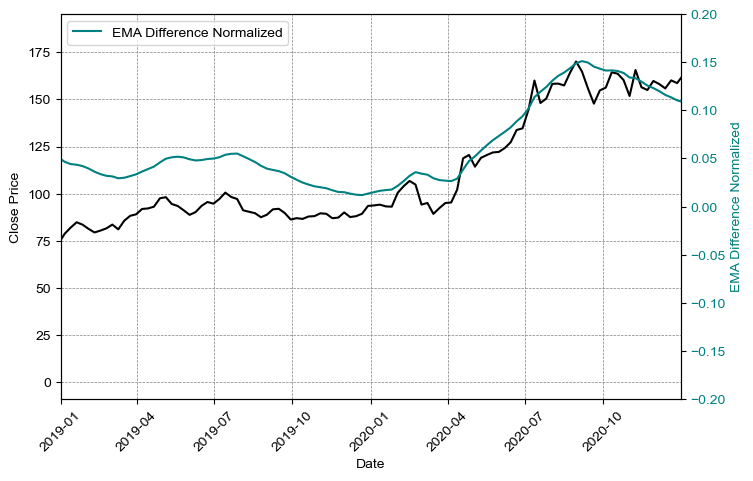

In [5]:
plt.style.use('default')

plt.rcParams['font.sans-serif'] = 'Arial'

fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(amzn['Date'], amzn['Close'], color='Black', label='Close')
ax.set_xlabel('Date')
ax.set_ylabel('Close Price', color='Black')

ax.grid(True, linestyle='--', linewidth=0.5, color='gray')

ax.set_xlim([pd.to_datetime('2019-01-01'), pd.to_datetime('2020-12-31')])
ax2 = ax.twinx()
ax2.plot(amzn['Date'], amzn['EMADN'], color='#008080', label='EMA Difference Normalized')
ax2.set_ylabel('EMA Difference Normalized', color='#008080')
ax2.tick_params(axis='y', labelcolor='#008080')
ax2.set_ylim([-0.2, 0.2])
ax2.legend(loc='upper left')

ax.xaxis.set_tick_params(rotation=45)

plt.savefig('EMADN.png', transparent=True)
plt.show()

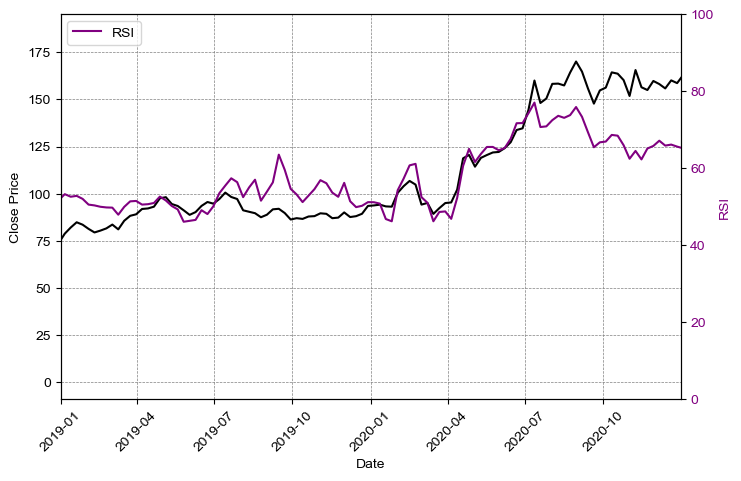

In [6]:
plt.rcParams['font.sans-serif'] = 'Arial'

fig, ax = plt.subplots(figsize=(8, 5))

ax.plot(amzn['Date'], amzn['Close'], color='Black', label='Close')
ax.set_xlabel('Date')
ax.set_ylabel('Close Price', color='Black')

ax.grid(True, linestyle='--', linewidth=0.5, color='gray')

ax.set_xlim([pd.to_datetime('2019-01-01'), pd.to_datetime('2020-12-31')])
ax2 = ax.twinx()
ax2.plot(amzn['Date'], amzn['RSI'], color='#800080', label='RSI')
ax2.set_ylabel('RSI', color='#800080')
ax2.set_ylim([0, 100])
ax2.tick_params(axis='y', labelcolor='#800080')
ax2.legend(loc='upper left')

ax.xaxis.set_tick_params(rotation=45)

plt.savefig('RSI.png', transparent=True)
plt.show()

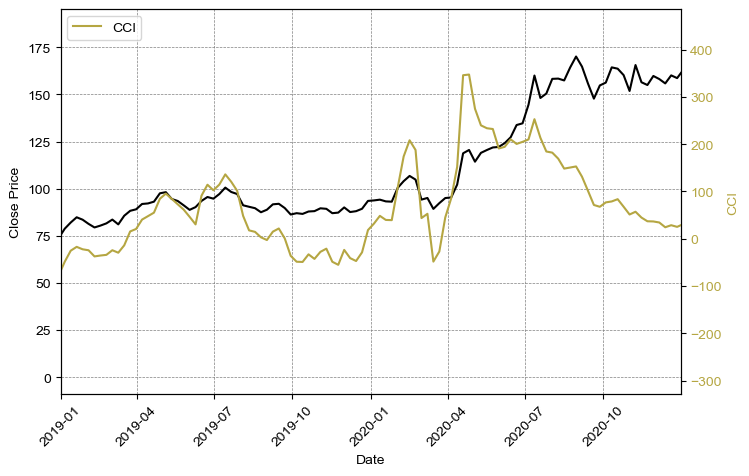

In [7]:
plt.rcParams['font.sans-serif'] = 'Arial'

fig, ax = plt.subplots(figsize=(8, 5))

ax.plot(amzn['Date'], amzn['Close'], color='Black', label='Close')
ax.set_xlabel('Date')
ax.set_ylabel('Close Price', color='Black')

ax.grid(True, linestyle='--', linewidth=0.5, color='gray')

ax.set_xlim([pd.to_datetime('2019-01-01'), pd.to_datetime('2020-12-31')])
ax2 = ax.twinx()
ax2.plot(amzn['Date'], amzn['CCI'], color='#B5A642', label='CCI')
ax2.set_ylabel('CCI', color='#B5A642')
ax2.tick_params(axis='y', labelcolor='#B5A642')
ax2.legend(loc='upper left')

ax.xaxis.set_tick_params(rotation=45)

plt.savefig('CCI.png', transparent=True)

plt.show()

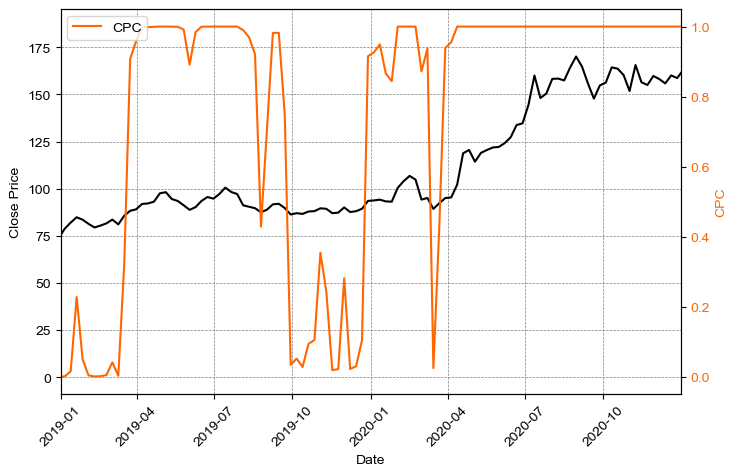

In [8]:
plt.rcParams['font.sans-serif'] = 'Arial'

fig, ax = plt.subplots(figsize=(8, 5))

ax.plot(amzn['Date'], amzn['Close'], color='Black', label='Close')
ax.set_xlabel('Date')
ax.set_ylabel('Close Price', color='Black')

ax.grid(True, linestyle='--', linewidth=0.5, color='gray')

ax.set_xlim([pd.to_datetime('2019-01-01'), pd.to_datetime('2020-12-31')])
ax2 = ax.twinx()
ax2.plot(amzn['Date'], amzn['CPC'], color='#FF6600', label='CPC')
ax2.set_ylabel('CPC', color='#FF6600')
ax2.tick_params(axis='y', labelcolor='#FF6600')
ax2.legend(loc='upper left')

ax.xaxis.set_tick_params(rotation=45)

plt.savefig('CPC.png', transparent=True)

plt.show()

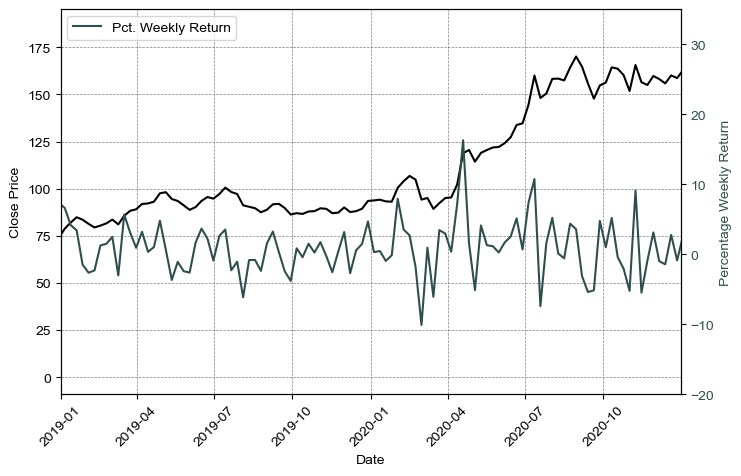

In [9]:
plt.style.use('default')

plt.rcParams['font.sans-serif'] = 'Arial'

fig, ax = plt.subplots(figsize=(8, 5))

ax.plot(amzn['Date'], amzn['Close'], color='Black', label='Close')
ax.set_xlabel('Date')
ax.set_ylabel('Close Price', color='Black')

ax.grid(True, linestyle='--', linewidth=0.5, color='gray')

ax.set_xlim([pd.to_datetime('2019-01-01'), pd.to_datetime('2020-12-31')])
ax2 = ax.twinx()
ax2.plot(amzn['Date'], amzn['Current_week_pct_change'], color='#2F4F4F', label='Pct. Weekly Return')
ax2.set_ylabel('Percentage Weekly Return', color='#2F4F4F')
ax2.set_ylim([-20, 35])
ax2.tick_params(axis='y', labelcolor='#2F4F4F')
ax2.legend(loc='upper left')

ax.xaxis.set_tick_params(rotation=45)

plt.savefig('PercentageReturn.png', transparent=True)

plt.show()

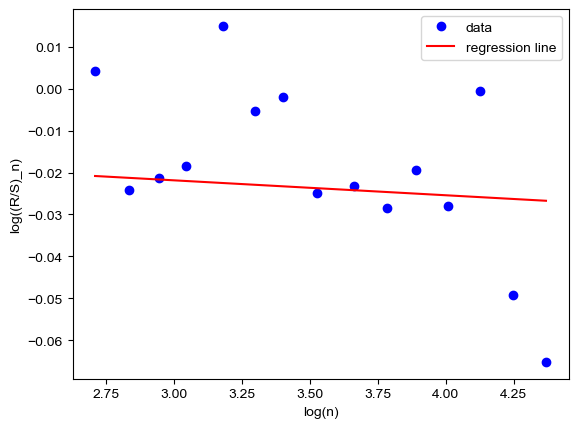

Hurst exponent (R/S estimate) for Weekly Return series: 0.5


In [10]:
H_rs=nolds.hurst_rs(data=amzn['Current_week_pct_change'], debug_plot=True)
print("Hurst exponent (R/S estimate) for Weekly Return series:", round(H_rs,2))

***
# Training and Validation
The model is trained on each dataset uning a 90-10 split. After each training, it will be cross-tested using the other test sets.

In [11]:
# Define your feature columns
feature_columns = ['RSI', 'CCI', 'CPC', 'EMADN', 'Current_week_pct_change']

# Define the membership functions for RSI and store in invars:
invars = [
    ('RSI', [
        membership.GaussMembFunc(0.5, 0.2),
        membership.SigmoidMembFunc(-10, 0.4), 
        membership.SigmoidMembFunc(10, 0.6)
    ]),
    ('CCI', [
        membership.GaussMembFunc(0.5, 0.2),
        membership.SigmoidMembFunc(-10, 0.4), 
        membership.SigmoidMembFunc(10, 0.6)
    ]),
    ('CPC', [
        membership.GaussMembFunc(0.5, 0.2),
        membership.SigmoidMembFunc(-10, 0.4), 
        membership.SigmoidMembFunc(10, 0.6)
    ]),
    ('EMADN', [
        membership.GaussMembFunc(0.5, 0.2),
        membership.SigmoidMembFunc(-10, 0.4), 
        membership.SigmoidMembFunc(10, 0.6)
    ]),
    ('RETURN',[
        membership.GaussMembFunc(0.5, 0.2),
        membership.SigmoidMembFunc(-10, 0.4), 
        membership.SigmoidMembFunc(10, 0.6)
    ])
]

# Instance the anfis classifier model, specifying the number of output classes
model = anfis.AnfisNetClassifier(invardefs=invars, num_classes=3)

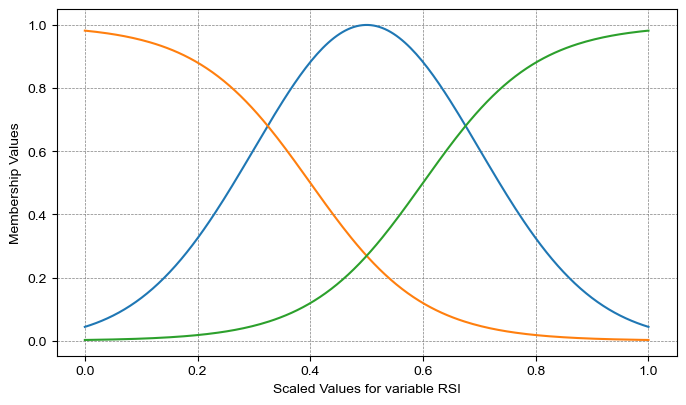

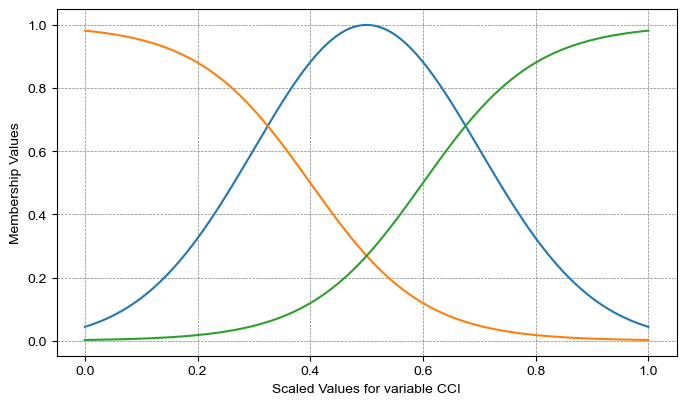

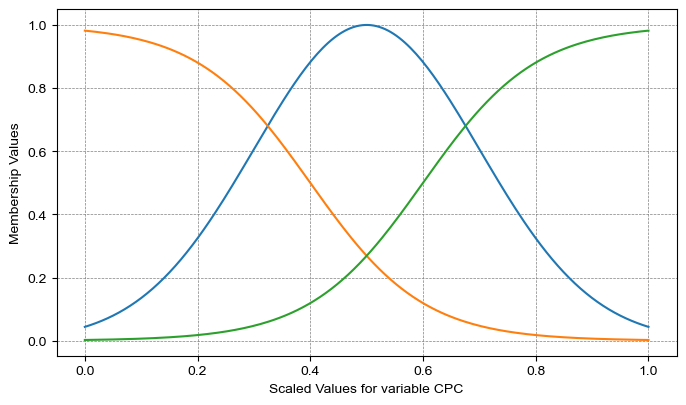

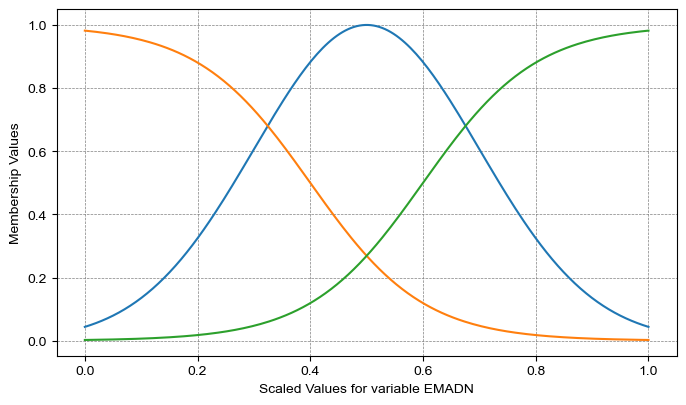

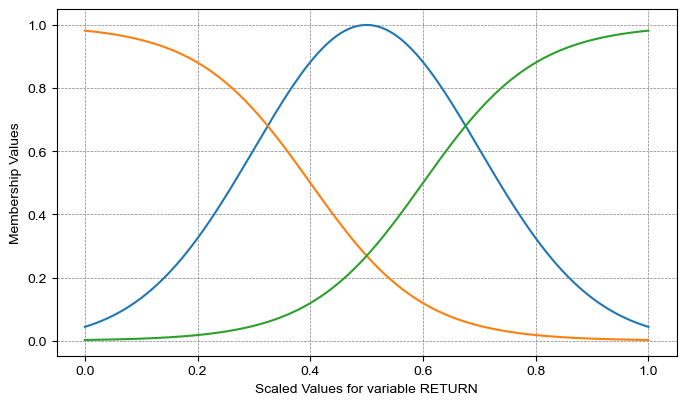

Initial Membership Functions:


In [12]:
num_points = 200
points_range = torch.linspace(0, 1, num_points)
x = torch.stack([points_range, points_range, points_range, points_range, points_range], dim=1)
experimental.plot_all_mfs(model, x)
print('Initial Membership Functions:')

***
## AMZN dataset

### Training for 500 epochs, training size = 1194 cases
epoch    0: Loss=1.09060
epoch   10: Loss=0.95458
epoch   20: Loss=0.92928
epoch   30: Loss=0.92157
epoch   40: Loss=0.91879
epoch   50: Loss=0.91686
epoch   60: Loss=0.91420
epoch   70: Loss=0.91178
epoch   80: Loss=0.90944
epoch   90: Loss=0.90680
epoch  100: Loss=0.90387
epoch  110: Loss=0.90055
epoch  120: Loss=0.89653
epoch  130: Loss=0.89315
epoch  140: Loss=0.89039
epoch  150: Loss=0.88822
epoch  160: Loss=0.88648
epoch  170: Loss=0.88503
epoch  180: Loss=0.88374
epoch  190: Loss=0.88263
epoch  200: Loss=0.88136
epoch  210: Loss=0.88030
epoch  220: Loss=0.87938
epoch  230: Loss=0.87856
epoch  240: Loss=0.87781
epoch  250: Loss=0.87710
epoch  260: Loss=0.87644
epoch  270: Loss=0.87594
epoch  280: Loss=0.87539
epoch  290: Loss=0.87442
epoch  300: Loss=0.87363
epoch  310: Loss=0.87295
epoch  320: Loss=0.87239
epoch  330: Loss=0.87198
epoch  340: Loss=0.87161
epoch  350: Loss=0.87055
epoch  360: Loss=0.86965
epoch  370: Loss=0.

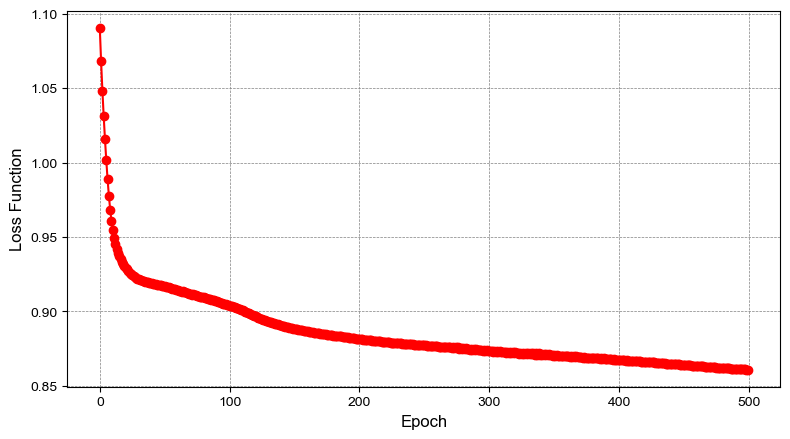

In [13]:
df=amzn
    
# Now let's prepare the features
features = df[feature_columns]
scaler = MinMaxScaler()
features = scaler.fit_transform(features)

# Prepare the target to fit the labeling used by pytorch {0,1,2}
target = df['Next_week_market_behavior']+1

# Calculate the index for the split
split_idx = int(len(features) * 0.9)

# Split the features and target into training/testing sets without shuffling
X_train = features[:split_idx]
X_test = features[split_idx:]
y_train = target.iloc[:split_idx]
y_test = target.iloc[split_idx:]

# Convert to PyTorch tensors
train_data = TensorDataset(torch.FloatTensor(X_train), torch.LongTensor(y_train.values))
test_data = TensorDataset(torch.FloatTensor(X_test), torch.LongTensor(y_test.values))

# Create Data Loaders
train_loader = DataLoader(train_data, batch_size=64, shuffle=False)  # Usually, you don't shuffle time series data
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

optimizer = torch.optim.Adam(model.parameters())
experimental.train_anfis_classifier_with(model=model, 
                                         data=train_loader, 
                                         optimizer=optimizer, 
                                         epochs=500, 
                                         show_plots=True)

Training Accuracy: 54.0 %
────────────────────────────────────────


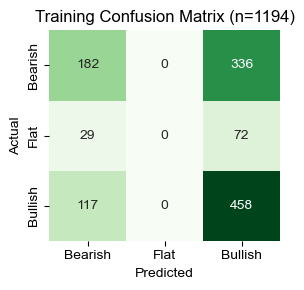

In [14]:
X_train_data = torch.FloatTensor(X_train)  # Convert features to a tensor
X_train_loader = DataLoader(X_train_data, batch_size=64, shuffle=False)
predicted_labels_train =experimental.classification_predictions(model, X_train_loader)

actual_labels_train =y_train-1
# Accuracy
accuracy = accuracy_score(actual_labels_train, predicted_labels_train)
print(f'Training Accuracy: {round(accuracy *100, 0)} %')
print('─' * 40)

# Confusion Matrix
train_conf_matrix = confusion_matrix(actual_labels_train, predicted_labels_train)

plt.figure(figsize=(3,3))
sns.heatmap(train_conf_matrix, annot=True, cmap='Greens', cbar=False, xticklabels=['Bearish', 'Flat', 'Bullish'], yticklabels=['Bearish', 'Flat', 'Bullish'], fmt='d')

plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.title(f'Training Confusion Matrix (n={len(X_train)})')

plt.tight_layout()
#plt.savefig('training_confusion_matrix.png', transparent=True, dpi=300)
plt.show()

Validation Accuracy: 47.0 %
────────────────────────────────────────


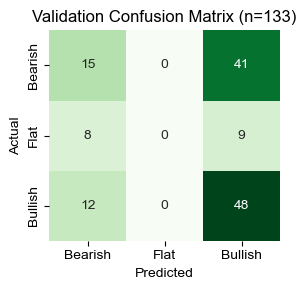

In [15]:
X_test_data = torch.FloatTensor(X_test)  # Convert features to a tensor
X_test_loader = DataLoader(X_test_data, batch_size=64, shuffle=False)
predicted_labels_test=experimental.classification_predictions(model, X_test_loader)

actual_labels_test=y_test-1
# Accuracy
accuracy = accuracy_score(actual_labels_test, predicted_labels_test)
print(f'Validation Accuracy: {round(accuracy *100, 0)} %')
print('─' * 40)

# Confusion Matrix
test_conf_matrix = confusion_matrix(actual_labels_test, predicted_labels_test)

plt.figure(figsize=(3,3))
sns.heatmap(test_conf_matrix, annot=True, cmap='Greens', cbar=False, xticklabels=['Bearish', 'Flat', 'Bullish'], yticklabels=['Bearish', 'Flat', 'Bullish'], fmt='d')

plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.title(f'Validation Confusion Matrix (n={len(X_test)})')

plt.tight_layout()
#plt.savefig('test_confusion_matrix.png', transparent=True, dpi=300)
plt.show()

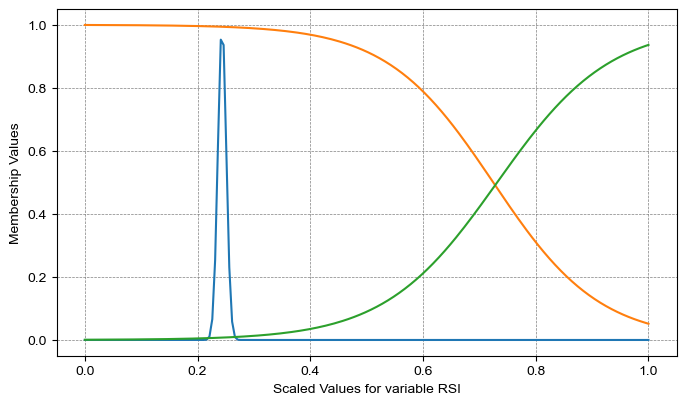

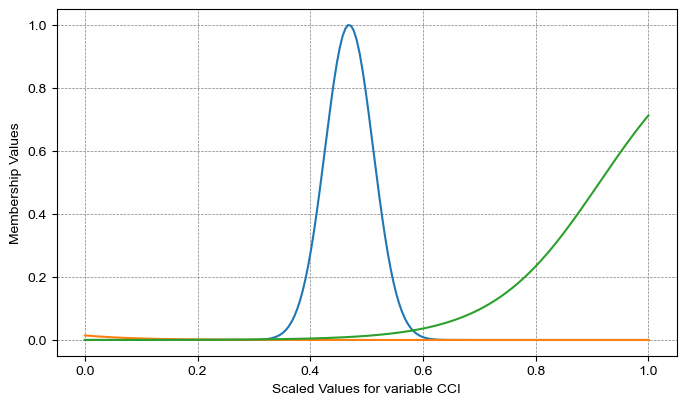

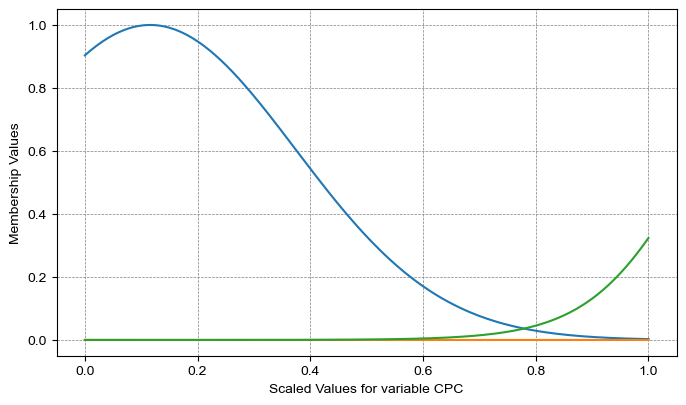

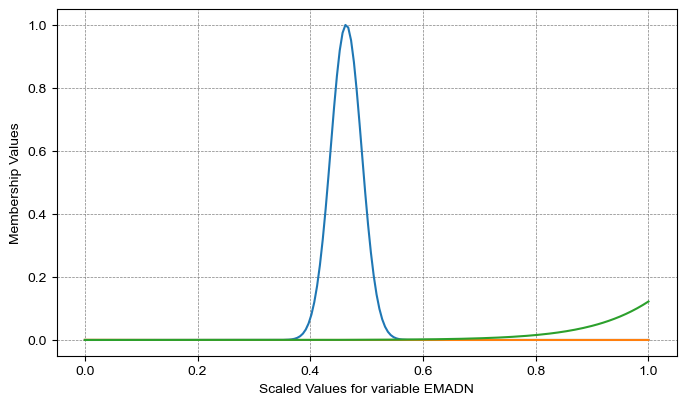

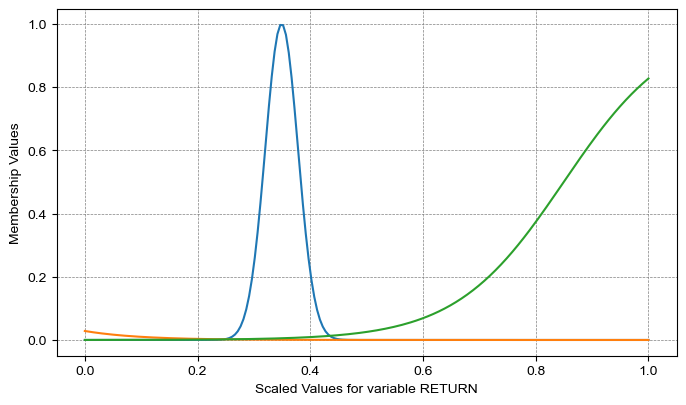

Membership Functions after training:


In [16]:
num_points = 200
points_range = torch.linspace(0, 1, num_points)
x = torch.stack([points_range, points_range, points_range, points_range, points_range], dim=1)
experimental.plot_all_mfs(model, x)
print('Membership Functions after training:')

Cumulative return over the period: 939607.2 %
Baseline Return (Buy and Hold over the period): 19120.8 %
Maximum Drawdown Duration 202 weeks


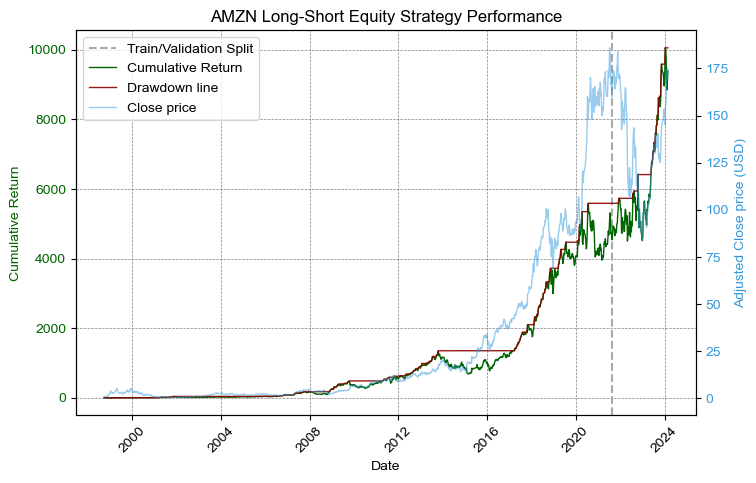

In [17]:
# Combine predictions into a single column
amzn['Prediction'] = np.concatenate([predicted_labels_train, predicted_labels_test])

amzn=utilities.calculate_returns(amzn, 'Prediction')

max_drawdown_duration=utilities.calculate_max_drawdown_duration(amzn)

print(f'Maximum Drawdown Duration {max_drawdown_duration} weeks')

utilities.plot_return(amzn, 'AMZN', train_test_split=0.9, save_figure=False)

Cumulative return over the period: 100.9 %
Baseline Return (Buy and Hold over the period): 6.2 %
Validation Set Maximum Drawdown: 32 weeks


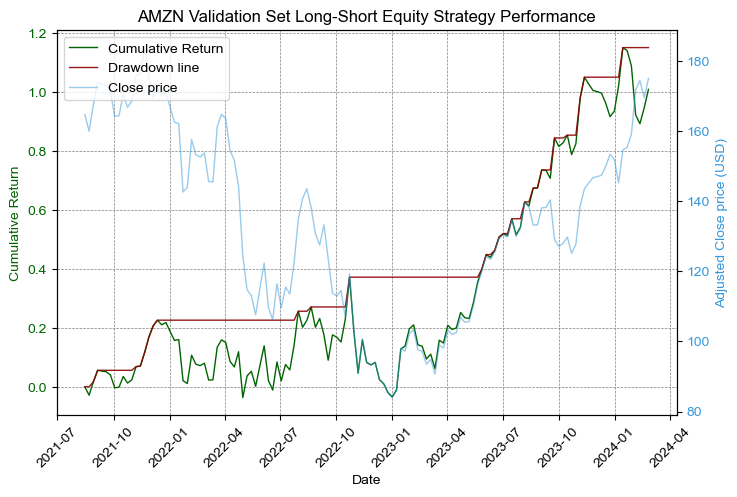

Yearly Returns and Drawdowns:
────────────────────────────────────────
Cumulative return over the period: 20.2 %
Baseline Return (Buy and Hold over the period): -14.5 %
Start Date: 2021-08-15
End Date: 2022-08-07
Maximum drawdown during the period: 32 weeks
────────────────────────────────────────
Cumulative return over the period: 32.8 %
Baseline Return (Buy and Hold over the period): -2.8 %
Start Date: 2022-08-14
End Date: 2023-08-06
Maximum drawdown during the period: 30 weeks
────────────────────────────────────────


In [18]:
split_idx=int(len(amzn)*0.9)
amzn_test_df=amzn[split_idx:]
amzn_test_df = utilities.calculate_returns(amzn_test_df, 'Prediction')
max_drawdown_duration_test = utilities.calculate_max_drawdown_duration(amzn_test_df)
print(f'Validation Set Maximum Drawdown: {max_drawdown_duration_test} weeks')
utilities.plot_return(amzn_test_df, 'AMZN Validation Set')
utilities.calculate_yearly_returns(amzn_test_df)

Cross-testing on IBM Test
Cross-Test Accuracy: 43.0 %
────────────────────────────────────────
Cumulative return over the period: 16.2 %
Baseline Return (Buy and Hold over the period): 45.3 %
Maximum Drawdown Duration 22 weeks
────────────────────────────────────────


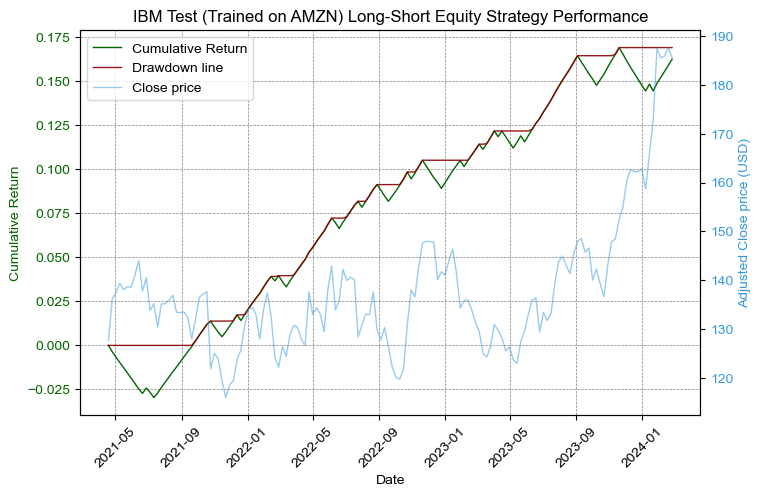

Yearly Returns and Drawdowns:
────────────────────────────────────────
Cumulative return over the period: 4.6 %
Baseline Return (Buy and Hold over the period): 0.2 %
Start Date: 2021-04-18
End Date: 2022-04-10
Maximum drawdown during the period: 22 weeks
────────────────────────────────────────
Cumulative return over the period: 6.6 %
Baseline Return (Buy and Hold over the period): 2.6 %
Start Date: 2022-04-17
End Date: 2023-04-09
Maximum drawdown during the period: 12 weeks
────────────────────────────────────────
────────────────────────────────────────────────────────────────────────────────────────────────────
Cross-testing on MSFT Test
Cross-Test Accuracy: 49.0 %
────────────────────────────────────────
Cumulative return over the period: 25.6 %
Baseline Return (Buy and Hold over the period): 57.2 %
Maximum Drawdown Duration 20 weeks
────────────────────────────────────────


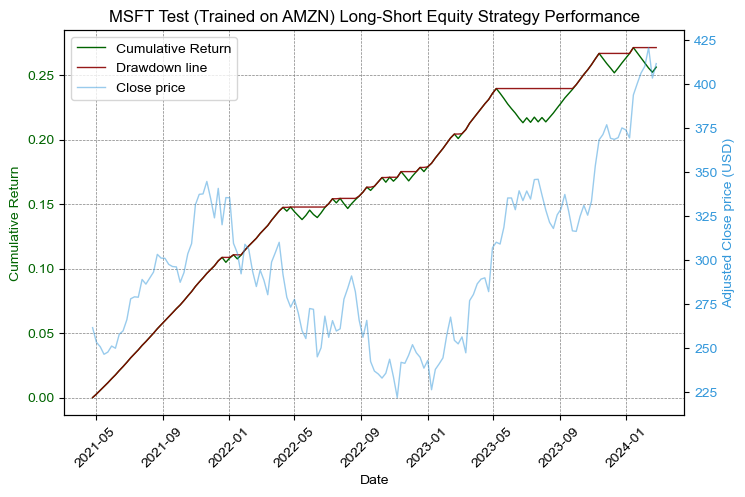

Yearly Returns and Drawdowns:
────────────────────────────────────────
Cumulative return over the period: 14.5 %
Baseline Return (Buy and Hold over the period): 6.6 %
Start Date: 2021-04-25
End Date: 2022-04-17
Maximum drawdown during the period: 2 weeks
────────────────────────────────────────
Cumulative return over the period: 7.0 %
Baseline Return (Buy and Hold over the period): 6.1 %
Start Date: 2022-04-24
End Date: 2023-04-16
Maximum drawdown during the period: 9 weeks
────────────────────────────────────────
────────────────────────────────────────────────────────────────────────────────────────────────────
Cross-testing on S&P500 Test
Cross-Test Accuracy: 44.0 %
────────────────────────────────────────
Cumulative return over the period: 21.6 %
Baseline Return (Buy and Hold over the period): 21.7 %
Maximum Drawdown Duration 43 weeks
────────────────────────────────────────


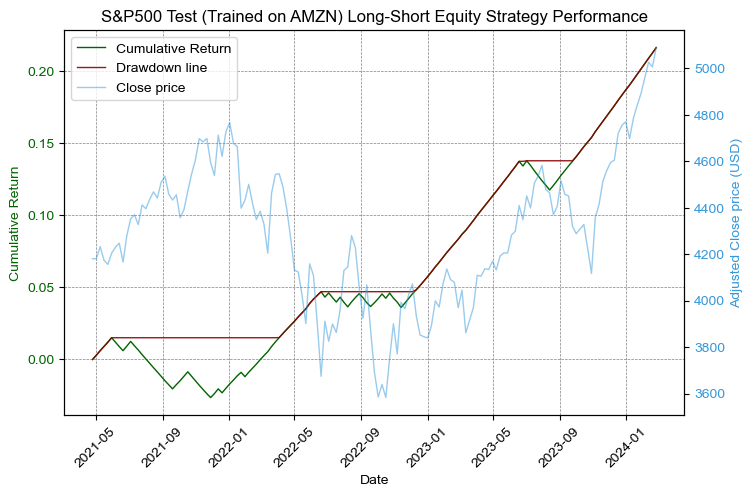

Yearly Returns and Drawdowns:
────────────────────────────────────────
Cumulative return over the period: 2.1 %
Baseline Return (Buy and Hold over the period): 5.1 %
Start Date: 2021-04-25
End Date: 2022-04-17
Maximum drawdown during the period: 43 weeks
────────────────────────────────────────
Cumulative return over the period: 8.1 %
Baseline Return (Buy and Hold over the period): -3.1 %
Start Date: 2022-04-24
End Date: 2023-04-16
Maximum drawdown during the period: 24 weeks
────────────────────────────────────────
────────────────────────────────────────────────────────────────────────────────────────────────────
Cross-testing on NASDAQ Test
Cross-Test Accuracy: 47.0 %
────────────────────────────────────────
Cumulative return over the period: 36.7 %
Baseline Return (Buy and Hold over the period): 14.1 %
Maximum Drawdown Duration 13 weeks
────────────────────────────────────────


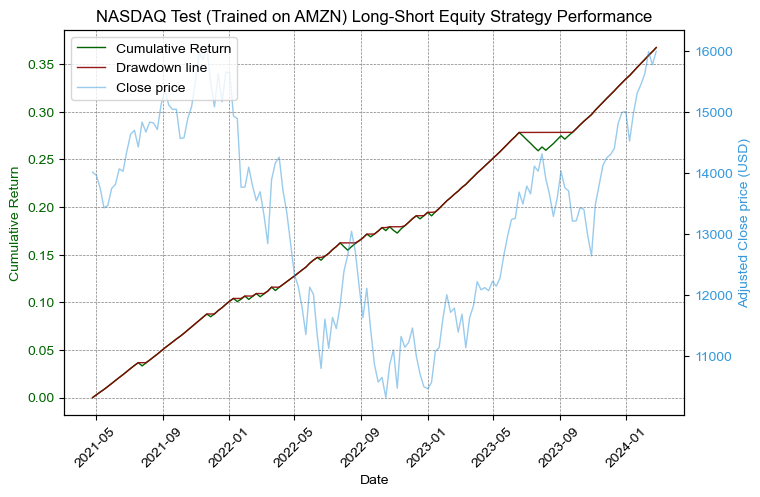

Yearly Returns and Drawdowns:
────────────────────────────────────────
Cumulative return over the period: 12.2 %
Baseline Return (Buy and Hold over the period): -4.7 %
Start Date: 2021-04-25
End Date: 2022-04-17
Maximum drawdown during the period: 2 weeks
────────────────────────────────────────
Cumulative return over the period: 10.5 %
Baseline Return (Buy and Hold over the period): -5.6 %
Start Date: 2022-04-24
End Date: 2023-04-16
Maximum drawdown during the period: 4 weeks
────────────────────────────────────────
────────────────────────────────────────────────────────────────────────────────────────────────────
Cross-testing on CAC Test
Cross-Test Accuracy: 44.0 %
────────────────────────────────────────
Cumulative return over the period: 24.2 %
Baseline Return (Buy and Hold over the period): 27.3 %
Maximum Drawdown Duration 52 weeks
────────────────────────────────────────


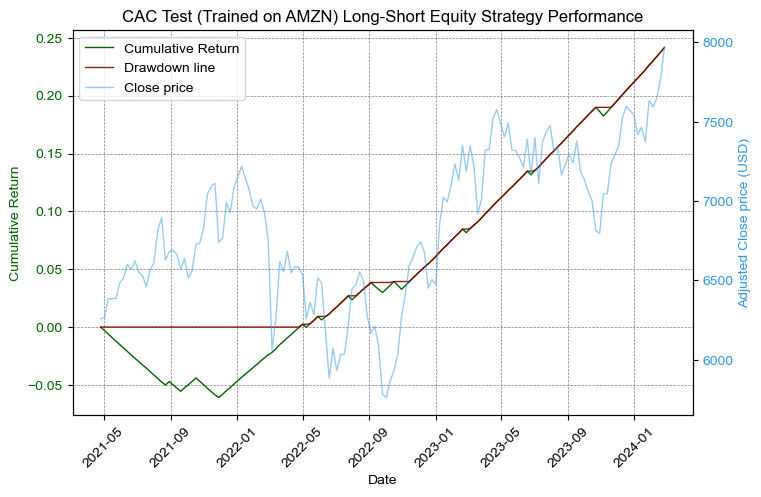

Yearly Returns and Drawdowns:
────────────────────────────────────────
Cumulative return over the period: -0.3 %
Baseline Return (Buy and Hold over the period): 5.3 %
Start Date: 2021-04-25
End Date: 2022-04-17
Maximum drawdown during the period: 51 weeks
────────────────────────────────────────
Cumulative return over the period: 10.5 %
Baseline Return (Buy and Hold over the period): 14.3 %
Start Date: 2022-04-24
End Date: 2023-04-16
Maximum drawdown during the period: 5 weeks
────────────────────────────────────────
────────────────────────────────────────────────────────────────────────────────────────────────────


In [19]:
# Defining and preparing the dataframe subsets to use for cross-testing models
def prepare_test_df(df, name):
    split_idx = int(len(df) * 0.9)
    test_df = df.iloc[split_idx:].drop(columns=['Open', 'High', 'Low']).copy()
    
    # Apply the MinMaxScaler, fitted on the dataset that the model was trained on
    features = test_df[feature_columns]
    scaled_features = scaler.transform(features)
    
    # Store the scaled features back into the DataFrame
    test_df[feature_columns] = scaled_features
    
    return test_df, name

# Prepare each DataFrame
ibm_test_df, ibm_name = prepare_test_df(ibm, 'IBM Test')
msft_test_df, msft_name = prepare_test_df(msft, 'MSFT Test')
sp500_test_df, sp500_name = prepare_test_df(sp500, 'S&P500 Test')
nasdaq_test_df, nasdaq_name = prepare_test_df(nasdaq, 'NASDAQ Test')
cac_test_df, cac_name = prepare_test_df(cac, 'CAC Test')

# Create a dictionary for better readability and access
test_dfs = {
    ibm_name: ibm_test_df,
    msft_name: msft_test_df,
    sp500_name: sp500_test_df,
    nasdaq_name: nasdaq_test_df,
    cac_name: cac_test_df
}

for df_name, df in test_dfs.items():

    actual_labels_test = df['Next_week_market_behavior']
    
    X_test = df[feature_columns].values
    
    X_test_data = torch.FloatTensor(X_test)  # Convert features to a tensor
    X_test_loader = DataLoader(X_test_data, batch_size=64, shuffle=False)

    predicted_labels_test=experimental.classification_predictions(model, X_test_loader)

    print(f'Cross-testing on {df_name}')
    # Accuracy
    accuracy = accuracy_score(actual_labels_test, predicted_labels_test)
    print(f'Cross-Test Accuracy: {round(accuracy *100, 0)} %')
    print('─' * 40)

    # Returns
    df['Prediction'] = predicted_labels_test

    df=utilities.calculate_returns(df, 'Prediction')
    
    max_drawdown_duration=utilities.calculate_max_drawdown_duration(df)
    
    print(f'Maximum Drawdown Duration {max_drawdown_duration} weeks')
    print('─' * 40) 

    utilities.plot_return(df, df_name+' (Trained on AMZN)', save_figure=True)

    utilities.calculate_yearly_returns(df)

    print('─' * 100)

***
## MSFT dataset

### Training for 500 epochs, training size = 1339 cases
epoch    0: Loss=1.60848
epoch   10: Loss=1.03871
epoch   20: Loss=1.00957
epoch   30: Loss=1.00103
epoch   40: Loss=0.98785
epoch   50: Loss=0.98206
epoch   60: Loss=0.97407
epoch   70: Loss=0.96899
epoch   80: Loss=0.96571
epoch   90: Loss=0.96410
epoch  100: Loss=0.96218
epoch  110: Loss=0.95992
epoch  120: Loss=0.95791
epoch  130: Loss=0.95619
epoch  140: Loss=0.95454
epoch  150: Loss=0.95293
epoch  160: Loss=0.95138
epoch  170: Loss=0.94991
epoch  180: Loss=0.94853
epoch  190: Loss=0.94723
epoch  200: Loss=0.94598
epoch  210: Loss=0.94475
epoch  220: Loss=0.94349
epoch  230: Loss=0.94219
epoch  240: Loss=0.94096
epoch  250: Loss=0.93986
epoch  260: Loss=0.93882
epoch  270: Loss=0.93783
epoch  280: Loss=0.93693
epoch  290: Loss=0.93608
epoch  300: Loss=0.93525
epoch  310: Loss=0.93443
epoch  320: Loss=0.93365
epoch  330: Loss=0.93290
epoch  340: Loss=0.93210
epoch  350: Loss=0.93180
epoch  360: Loss=0.93127
epoch  370: Loss=0.

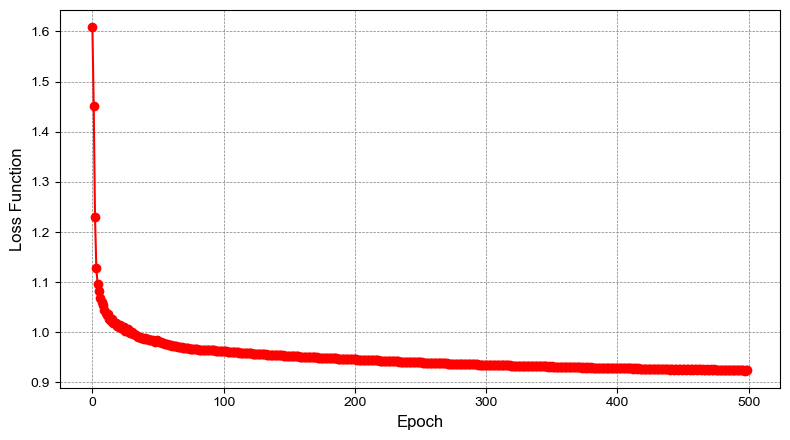

In [20]:
df=msft
    
# Now let's prepare the features
features = df[feature_columns]
scaler = MinMaxScaler()
features = scaler.fit_transform(features)

# Prepare the target to fit the labeling used by pytorch {0,1,2}
target = df['Next_week_market_behavior']+1

# Calculate the index for the split
split_idx = int(len(features) * 0.9)

# Split the features and target into training/testing sets without shuffling
X_train = features[:split_idx]
X_test = features[split_idx:]
y_train = target.iloc[:split_idx]
y_test = target.iloc[split_idx:]

# Convert to PyTorch tensors
train_data = TensorDataset(torch.FloatTensor(X_train), torch.LongTensor(y_train.values))
test_data = TensorDataset(torch.FloatTensor(X_test), torch.LongTensor(y_test.values))

# Create Data Loaders
train_loader = DataLoader(train_data, batch_size=64, shuffle=False)  # Usually, you don't shuffle time series data
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

optimizer = torch.optim.Adam(model.parameters())
experimental.train_anfis_classifier_with(model=model, 
                                         data=train_loader, 
                                         optimizer=optimizer, 
                                         epochs=500, 
                                         show_plots=True)

Training Accuracy: 53.0 %
────────────────────────────────────────


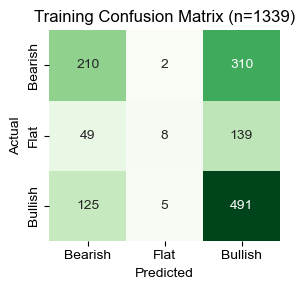

In [21]:
X_train_data = torch.FloatTensor(X_train)  # Convert features to a tensor
X_train_loader = DataLoader(X_train_data, batch_size=64, shuffle=False)
predicted_labels_train =experimental.classification_predictions(model, X_train_loader)

actual_labels_train =y_train-1
# Accuracy
accuracy = accuracy_score(actual_labels_train, predicted_labels_train)
print(f'Training Accuracy: {round(accuracy *100, 0)} %')
print('─' * 40)

# Confusion Matrix
train_conf_matrix = confusion_matrix(actual_labels_train, predicted_labels_train)

plt.figure(figsize=(3,3))
sns.heatmap(train_conf_matrix, annot=True, cmap='Greens', cbar=False, xticklabels=['Bearish', 'Flat', 'Bullish'], yticklabels=['Bearish', 'Flat', 'Bullish'], fmt='d')

plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.title(f'Training Confusion Matrix (n={len(X_train)})')

plt.tight_layout()
#plt.savefig('training_confusion_matrix.png', transparent=True, dpi=300)
plt.show()

Validation Accuracy: 46.0 %
────────────────────────────────────────


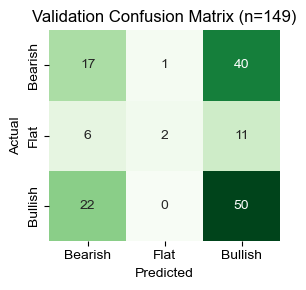

In [22]:
X_test_data = torch.FloatTensor(X_test)  # Convert features to a tensor
X_test_loader = DataLoader(X_test_data, batch_size=64, shuffle=False)
predicted_labels_test=experimental.classification_predictions(model, X_test_loader)

actual_labels_test=y_test-1
# Accuracy
accuracy = accuracy_score(actual_labels_test, predicted_labels_test)
print(f'Validation Accuracy: {round(accuracy *100, 0)} %')
print('─' * 40)

# Confusion Matrix
test_conf_matrix = confusion_matrix(actual_labels_test, predicted_labels_test)

plt.figure(figsize=(3,3))
sns.heatmap(test_conf_matrix, annot=True, cmap='Greens', cbar=False, xticklabels=['Bearish', 'Flat', 'Bullish'], yticklabels=['Bearish', 'Flat', 'Bullish'], fmt='d')

plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.title(f'Validation Confusion Matrix (n={len(X_test)})')

plt.tight_layout()
#plt.savefig('test_confusion_matrix.png', transparent=True, dpi=300)
plt.show()

Cumulative return over the period: 444652.5 %
Baseline Return (Buy and Hold over the period): 6875.7 %
Maximum Drawdown Duration 202 weeks


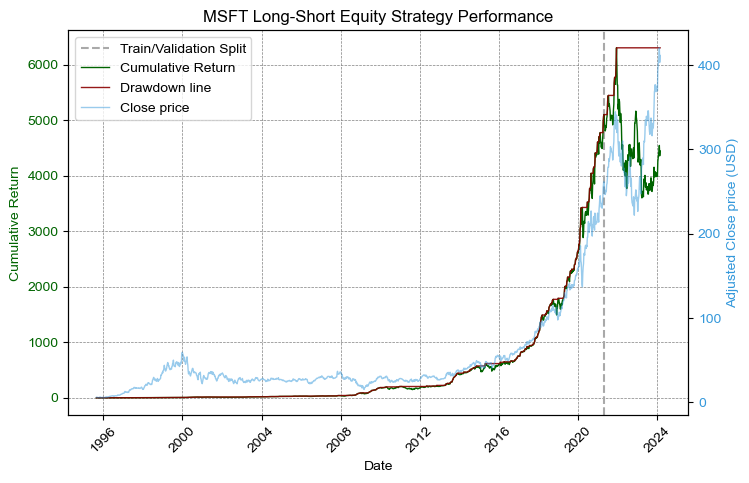

In [23]:
# Combine predictions into a single column
df['Prediction'] = np.concatenate([predicted_labels_train, predicted_labels_test])

df=utilities.calculate_returns(df, 'Prediction')

max_drawdown_duration=utilities.calculate_max_drawdown_duration(amzn)

print(f'Maximum Drawdown Duration {max_drawdown_duration} weeks')

utilities.plot_return(df, 'MSFT', train_test_split=0.9, save_figure=True)

Cumulative return over the period: -12.8 %
Baseline Return (Buy and Hold over the period): 57.2 %
Validation Set Maximum Drawdown: 115 weeks


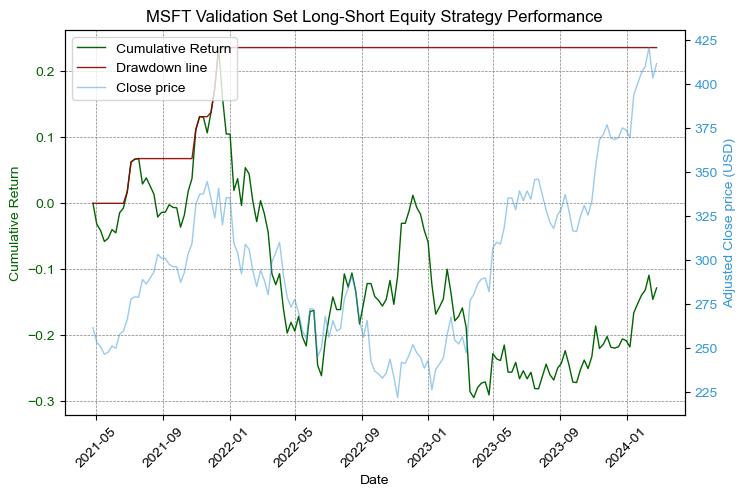

Yearly Returns and Drawdowns:
────────────────────────────────────────
Cumulative return over the period: -19.6 %
Baseline Return (Buy and Hold over the period): 6.6 %
Start Date: 2021-04-25
End Date: 2022-04-17
Maximum drawdown during the period: 18 weeks
────────────────────────────────────────
Cumulative return over the period: -11.0 %
Baseline Return (Buy and Hold over the period): 6.1 %
Start Date: 2022-04-24
End Date: 2023-04-16
Maximum drawdown during the period: 19 weeks
────────────────────────────────────────


In [24]:
split_idx=int(len(msft)*0.9)
msft_test_df=msft[split_idx:]
msft_test_df = utilities.calculate_returns(msft_test_df, 'Prediction')
max_drawdown_duration_test = utilities.calculate_max_drawdown_duration(msft_test_df)
print(f'Validation Set Maximum Drawdown: {max_drawdown_duration_test} weeks')
utilities.plot_return(msft_test_df, 'MSFT Validation Set', save_figure=True)
utilities.calculate_yearly_returns(msft_test_df)

Cross-testing on IBM Test
Cross-Test Accuracy: 41.0 %
────────────────────────────────────────
Cumulative return over the period: 19.2 %
Baseline Return (Buy and Hold over the period): 45.3 %
Maximum Drawdown Duration 20 weeks
────────────────────────────────────────


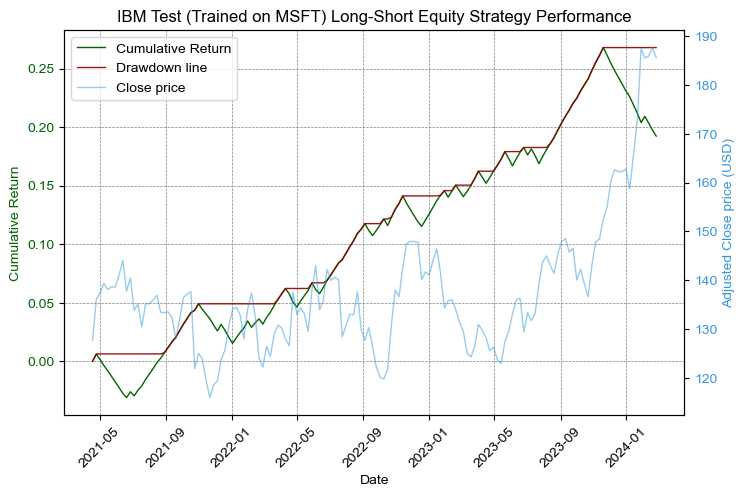

Yearly Returns and Drawdowns:
────────────────────────────────────────
Cumulative return over the period: 6.2 %
Baseline Return (Buy and Hold over the period): 0.2 %
Start Date: 2021-04-18
End Date: 2022-04-10
Maximum drawdown during the period: 20 weeks
────────────────────────────────────────
Cumulative return over the period: 9.4 %
Baseline Return (Buy and Hold over the period): 2.6 %
Start Date: 2022-04-17
End Date: 2023-04-09
Maximum drawdown during the period: 9 weeks
────────────────────────────────────────
────────────────────────────────────────────────────────────────────────────────────────────────────
Cross-testing on AMZN Test
Cross-Test Accuracy: 46.0 %
────────────────────────────────────────
Cumulative return over the period: 22.9 %
Baseline Return (Buy and Hold over the period): 6.2 %
Maximum Drawdown Duration 57 weeks
────────────────────────────────────────


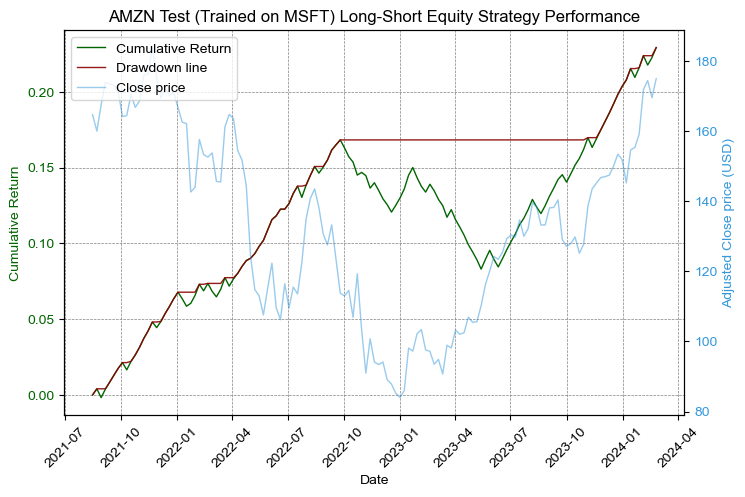

Yearly Returns and Drawdowns:
────────────────────────────────────────
Cumulative return over the period: 14.5 %
Baseline Return (Buy and Hold over the period): -14.5 %
Start Date: 2021-08-15
End Date: 2022-08-07
Maximum drawdown during the period: 4 weeks
────────────────────────────────────────
Cumulative return over the period: -1.9 %
Baseline Return (Buy and Hold over the period): -2.8 %
Start Date: 2022-08-14
End Date: 2023-08-06
Maximum drawdown during the period: 45 weeks
────────────────────────────────────────
────────────────────────────────────────────────────────────────────────────────────────────────────
Cross-testing on S&P500 Test
Cross-Test Accuracy: 48.0 %
────────────────────────────────────────
Cumulative return over the period: 57.8 %
Baseline Return (Buy and Hold over the period): 21.7 %
Maximum Drawdown Duration 24 weeks
────────────────────────────────────────


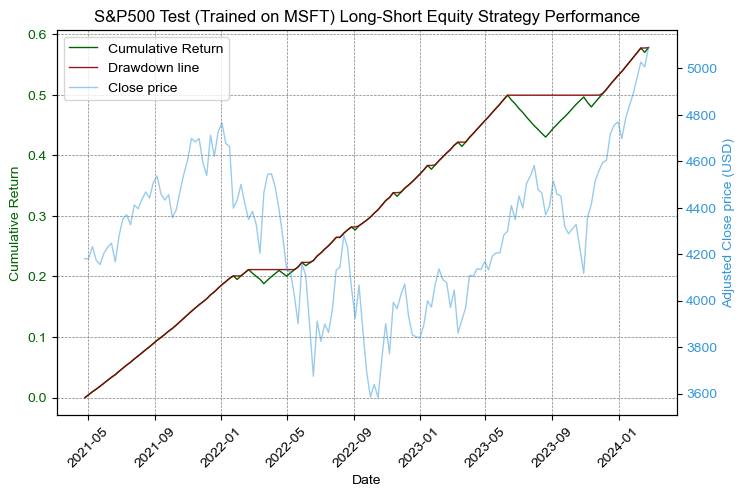

Yearly Returns and Drawdowns:
────────────────────────────────────────
Cumulative return over the period: 21.0 %
Baseline Return (Buy and Hold over the period): 5.1 %
Start Date: 2021-04-25
End Date: 2022-04-17
Maximum drawdown during the period: 8 weeks
────────────────────────────────────────
Cumulative return over the period: 19.8 %
Baseline Return (Buy and Hold over the period): -3.1 %
Start Date: 2022-04-24
End Date: 2023-04-16
Maximum drawdown during the period: 2 weeks
────────────────────────────────────────
────────────────────────────────────────────────────────────────────────────────────────────────────
Cross-testing on NASDAQ Test
Cross-Test Accuracy: 43.0 %
────────────────────────────────────────
Cumulative return over the period: 30.3 %
Baseline Return (Buy and Hold over the period): 14.1 %
Maximum Drawdown Duration 77 weeks
────────────────────────────────────────


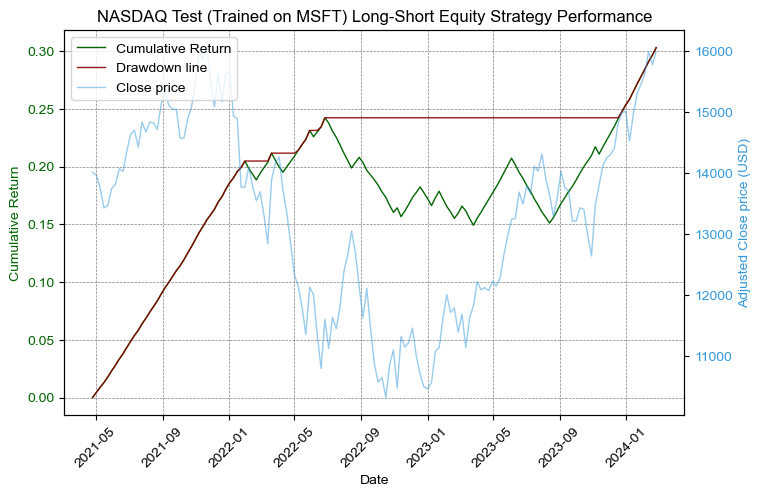

Yearly Returns and Drawdowns:
────────────────────────────────────────
Cumulative return over the period: 20.0 %
Baseline Return (Buy and Hold over the period): -4.7 %
Start Date: 2021-04-25
End Date: 2022-04-17
Maximum drawdown during the period: 6 weeks
────────────────────────────────────────
Cumulative return over the period: -3.2 %
Baseline Return (Buy and Hold over the period): -5.6 %
Start Date: 2022-04-24
End Date: 2023-04-16
Maximum drawdown during the period: 42 weeks
────────────────────────────────────────
────────────────────────────────────────────────────────────────────────────────────────────────────
Cross-testing on CAC Test
Cross-Test Accuracy: 50.0 %
────────────────────────────────────────
Cumulative return over the period: 56.3 %
Baseline Return (Buy and Hold over the period): 27.3 %
Maximum Drawdown Duration 15 weeks
────────────────────────────────────────


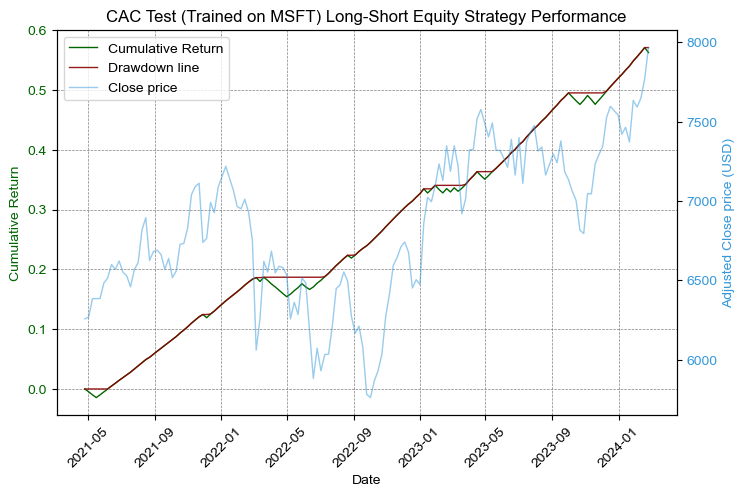

Yearly Returns and Drawdowns:
────────────────────────────────────────
Cumulative return over the period: 16.5 %
Baseline Return (Buy and Hold over the period): 5.3 %
Start Date: 2021-04-25
End Date: 2022-04-17
Maximum drawdown during the period: 6 weeks
────────────────────────────────────────
Cumulative return over the period: 17.6 %
Baseline Return (Buy and Hold over the period): 14.3 %
Start Date: 2022-04-24
End Date: 2023-04-16
Maximum drawdown during the period: 7 weeks
────────────────────────────────────────
────────────────────────────────────────────────────────────────────────────────────────────────────
Cross-testing on IBM Test
Cross-Test Accuracy: 41.0 %
────────────────────────────────────────
Cumulative return over the period: 19.2 %
Baseline Return (Buy and Hold over the period): 45.3 %
Maximum Drawdown Duration 20 weeks
────────────────────────────────────────


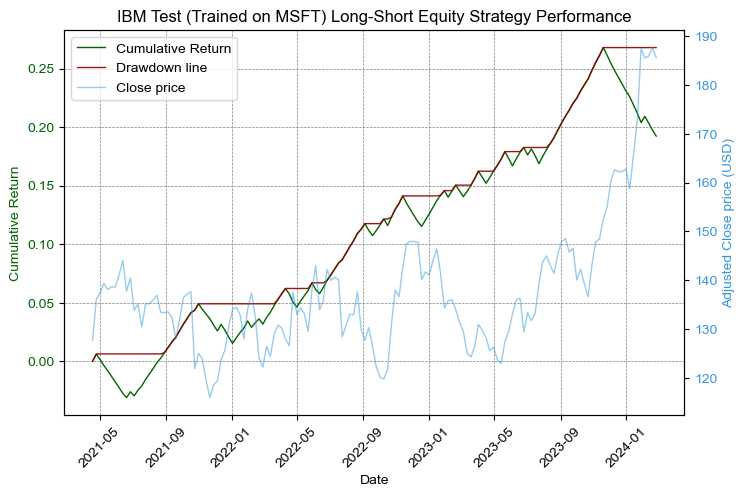

Yearly Returns and Drawdowns:
────────────────────────────────────────
Cumulative return over the period: 6.2 %
Baseline Return (Buy and Hold over the period): 0.2 %
Start Date: 2021-04-18
End Date: 2022-04-10
Maximum drawdown during the period: 20 weeks
────────────────────────────────────────
Cumulative return over the period: 9.4 %
Baseline Return (Buy and Hold over the period): 2.6 %
Start Date: 2022-04-17
End Date: 2023-04-09
Maximum drawdown during the period: 9 weeks
────────────────────────────────────────
────────────────────────────────────────────────────────────────────────────────────────────────────
Cross-testing on AMZN Test
Cross-Test Accuracy: 46.0 %
────────────────────────────────────────
Cumulative return over the period: 22.9 %
Baseline Return (Buy and Hold over the period): 6.2 %
Maximum Drawdown Duration 57 weeks
────────────────────────────────────────


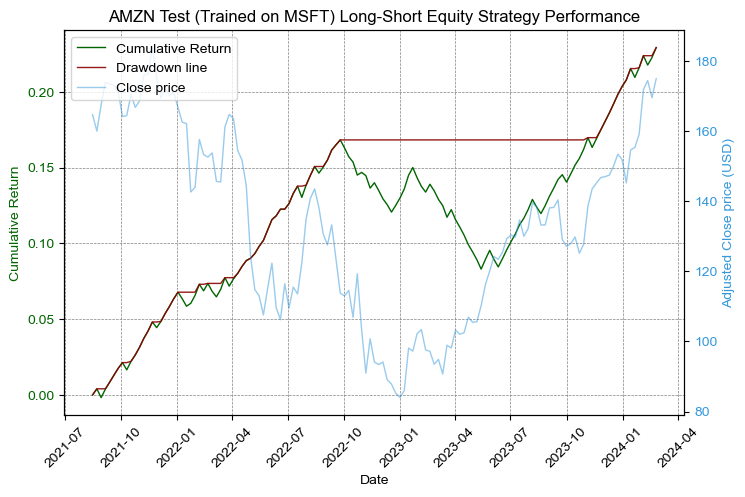

Yearly Returns and Drawdowns:
────────────────────────────────────────
Cumulative return over the period: 14.5 %
Baseline Return (Buy and Hold over the period): -14.5 %
Start Date: 2021-08-15
End Date: 2022-08-07
Maximum drawdown during the period: 4 weeks
────────────────────────────────────────
Cumulative return over the period: -1.9 %
Baseline Return (Buy and Hold over the period): -2.8 %
Start Date: 2022-08-14
End Date: 2023-08-06
Maximum drawdown during the period: 45 weeks
────────────────────────────────────────
────────────────────────────────────────────────────────────────────────────────────────────────────
Cross-testing on S&P500 Test
Cross-Test Accuracy: 48.0 %
────────────────────────────────────────
Cumulative return over the period: 57.8 %
Baseline Return (Buy and Hold over the period): 21.7 %
Maximum Drawdown Duration 24 weeks
────────────────────────────────────────


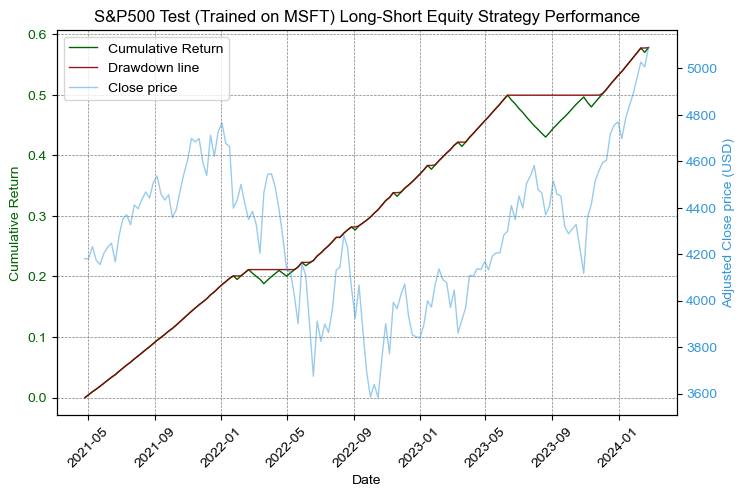

Yearly Returns and Drawdowns:
────────────────────────────────────────
Cumulative return over the period: 21.0 %
Baseline Return (Buy and Hold over the period): 5.1 %
Start Date: 2021-04-25
End Date: 2022-04-17
Maximum drawdown during the period: 8 weeks
────────────────────────────────────────
Cumulative return over the period: 19.8 %
Baseline Return (Buy and Hold over the period): -3.1 %
Start Date: 2022-04-24
End Date: 2023-04-16
Maximum drawdown during the period: 2 weeks
────────────────────────────────────────
────────────────────────────────────────────────────────────────────────────────────────────────────
Cross-testing on NASDAQ Test
Cross-Test Accuracy: 43.0 %
────────────────────────────────────────
Cumulative return over the period: 30.3 %
Baseline Return (Buy and Hold over the period): 14.1 %
Maximum Drawdown Duration 77 weeks
────────────────────────────────────────


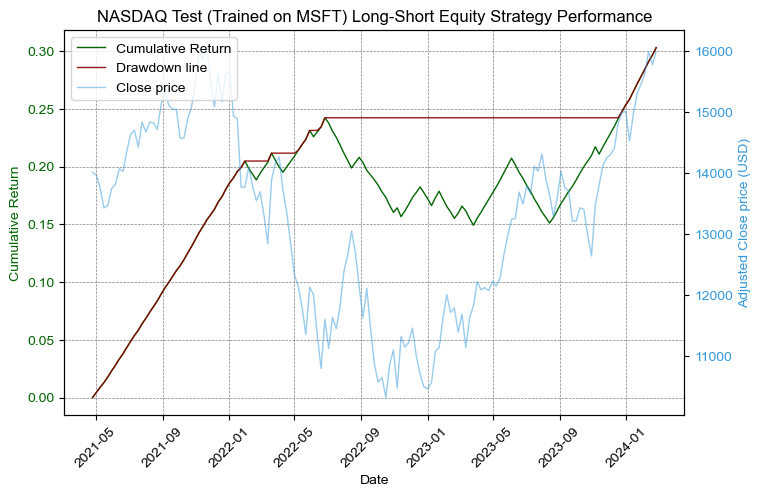

Yearly Returns and Drawdowns:
────────────────────────────────────────
Cumulative return over the period: 20.0 %
Baseline Return (Buy and Hold over the period): -4.7 %
Start Date: 2021-04-25
End Date: 2022-04-17
Maximum drawdown during the period: 6 weeks
────────────────────────────────────────
Cumulative return over the period: -3.2 %
Baseline Return (Buy and Hold over the period): -5.6 %
Start Date: 2022-04-24
End Date: 2023-04-16
Maximum drawdown during the period: 42 weeks
────────────────────────────────────────
────────────────────────────────────────────────────────────────────────────────────────────────────
Cross-testing on CAC Test
Cross-Test Accuracy: 50.0 %
────────────────────────────────────────
Cumulative return over the period: 56.3 %
Baseline Return (Buy and Hold over the period): 27.3 %
Maximum Drawdown Duration 15 weeks
────────────────────────────────────────


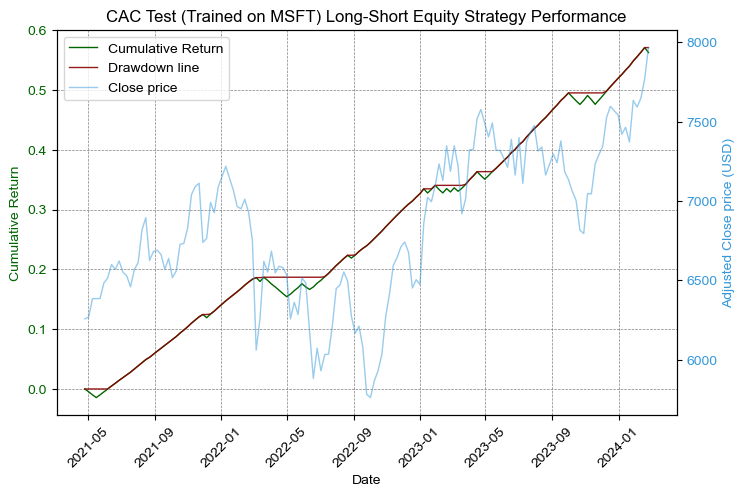

Yearly Returns and Drawdowns:
────────────────────────────────────────
Cumulative return over the period: 16.5 %
Baseline Return (Buy and Hold over the period): 5.3 %
Start Date: 2021-04-25
End Date: 2022-04-17
Maximum drawdown during the period: 6 weeks
────────────────────────────────────────
Cumulative return over the period: 17.6 %
Baseline Return (Buy and Hold over the period): 14.3 %
Start Date: 2022-04-24
End Date: 2023-04-16
Maximum drawdown during the period: 7 weeks
────────────────────────────────────────
────────────────────────────────────────────────────────────────────────────────────────────────────


In [25]:
# Defining and preparing the dataframe subsets to use for cross-testing models
def prepare_test_df(df, name):
    split_idx = int(len(df) * 0.9)
    test_df = df.iloc[split_idx:].drop(columns=['Open', 'High', 'Low']).copy()
    
    # Apply the MinMaxScaler, fitted on the dataset that the model was trained on
    features = test_df[feature_columns]
    scaled_features = scaler.transform(features)
    
    # Store the scaled features back into the DataFrame
    test_df[feature_columns] = scaled_features
    
    return test_df, name

# Prepare each DataFrame
ibm_test_df, ibm_name = prepare_test_df(ibm, 'IBM Test')
amzn_test_df, amzn_name = prepare_test_df(amzn, 'AMZN Test')
sp500_test_df, sp500_name = prepare_test_df(sp500, 'S&P500 Test')
nasdaq_test_df, nasdaq_name = prepare_test_df(nasdaq, 'NASDAQ Test')
cac_test_df, cac_name = prepare_test_df(cac, 'CAC Test')

# Create a dictionary for better readability and access
test_dfs = {
    ibm_name: ibm_test_df,
    amzn_name: amzn_test_df,
    sp500_name: sp500_test_df,
    nasdaq_name: nasdaq_test_df,
    cac_name: cac_test_df
}

for df_name, df in test_dfs.items():

    actual_labels_test = df['Next_week_market_behavior']
    
    X_test = df[feature_columns].values
    
    X_test_data = torch.FloatTensor(X_test)  # Convert features to a tensor
    X_test_loader = DataLoader(X_test_data, batch_size=64, shuffle=False)

    predicted_labels_test=experimental.classification_predictions(model, X_test_loader)

    print(f'Cross-testing on {df_name}')
    # Accuracy
    accuracy = accuracy_score(actual_labels_test, predicted_labels_test)
    print(f'Cross-Test Accuracy: {round(accuracy *100, 0)} %')
    print('─' * 40)

    # Returns
    df['Prediction'] = predicted_labels_test

    df=utilities.calculate_returns(df, 'Prediction')
    
    max_drawdown_duration=utilities.calculate_max_drawdown_duration(df)
    
    print(f'Maximum Drawdown Duration {max_drawdown_duration} weeks')
    print('─' * 40) 

    utilities.plot_return(df, df_name+' (Trained on MSFT)', save_figure=True)

    utilities.calculate_yearly_returns(df)

    print('─' * 100)

***
## IBM dataset

### Training for 500 epochs, training size = 1342 cases
epoch    0: Loss=1.22283
epoch   10: Loss=1.02694
epoch   20: Loss=1.00680
epoch   30: Loss=1.00044
epoch   40: Loss=0.99754
epoch   50: Loss=0.99553
epoch   60: Loss=0.99393
epoch   70: Loss=0.99246
epoch   80: Loss=0.99103
epoch   90: Loss=0.98981
epoch  100: Loss=0.98869
epoch  110: Loss=0.98668
epoch  120: Loss=0.98523
epoch  130: Loss=0.98463
epoch  140: Loss=0.98380
epoch  150: Loss=0.98336
epoch  160: Loss=0.98326
epoch  170: Loss=0.98251
epoch  180: Loss=0.98173
epoch  190: Loss=0.98156
epoch  200: Loss=0.98471
epoch  210: Loss=0.98539
epoch  220: Loss=0.98455
epoch  230: Loss=0.98378
epoch  240: Loss=0.98254
epoch  250: Loss=0.98164
epoch  260: Loss=0.98057
epoch  270: Loss=0.97941
epoch  280: Loss=0.97819
epoch  290: Loss=0.97679
epoch  300: Loss=0.97505
epoch  310: Loss=0.97349
epoch  320: Loss=0.97240
epoch  330: Loss=0.97158
epoch  340: Loss=0.97071
epoch  350: Loss=0.96983
epoch  360: Loss=0.96914
epoch  370: Loss=0.

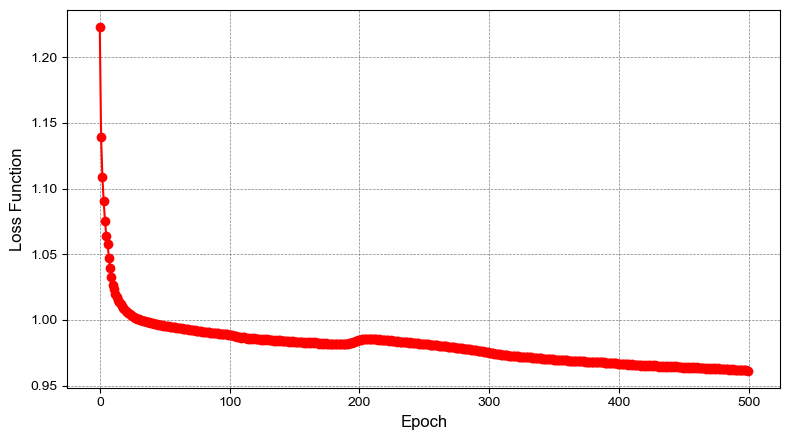

In [26]:
df=ibm
    
# Now let's prepare the features
features = df[feature_columns]
scaler = MinMaxScaler()
features = scaler.fit_transform(features)

# Prepare the target to fit the labeling used by pytorch {0,1,2}
target = df['Next_week_market_behavior']+1

# Calculate the index for the split
split_idx = int(len(features) * 0.9)

# Split the features and target into training/testing sets without shuffling
X_train = features[:split_idx]
X_test = features[split_idx:]
y_train = target.iloc[:split_idx]
y_test = target.iloc[split_idx:]

# Convert to PyTorch tensors
train_data = TensorDataset(torch.FloatTensor(X_train), torch.LongTensor(y_train.values))
test_data = TensorDataset(torch.FloatTensor(X_test), torch.LongTensor(y_test.values))

# Create Data Loaders
train_loader = DataLoader(train_data, batch_size=64, shuffle=False)  # Usually, you don't shuffle time series data
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

optimizer = torch.optim.Adam(model.parameters())
experimental.train_anfis_classifier_with(model=model, 
                                         data=train_loader, 
                                         optimizer=optimizer, 
                                         epochs=500, 
                                         show_plots=True)

Training Accuracy: 49.0 %
────────────────────────────────────────


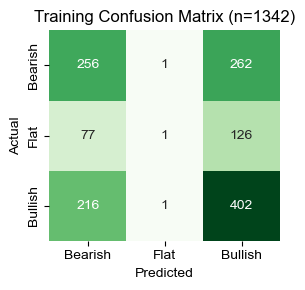

In [27]:
X_train_data = torch.FloatTensor(X_train)  # Convert features to a tensor
X_train_loader = DataLoader(X_train_data, batch_size=64, shuffle=False)
predicted_labels_train =experimental.classification_predictions(model, X_train_loader)

actual_labels_train =y_train-1
# Accuracy
accuracy = accuracy_score(actual_labels_train, predicted_labels_train)
print(f'Training Accuracy: {round(accuracy *100, 0)} %')
print('─' * 40)

# Confusion Matrix
train_conf_matrix = confusion_matrix(actual_labels_train, predicted_labels_train)

plt.figure(figsize=(3,3))
sns.heatmap(train_conf_matrix, annot=True, cmap='Greens', cbar=False, xticklabels=['Bearish', 'Flat', 'Bullish'], yticklabels=['Bearish', 'Flat', 'Bullish'], fmt='d')

plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.title(f'Training Confusion Matrix (n={len(X_train)})')

plt.tight_layout()
#plt.savefig('training_confusion_matrix.png', transparent=True, dpi=300)
plt.show()

Validation Accuracy: 38.0 %
────────────────────────────────────────


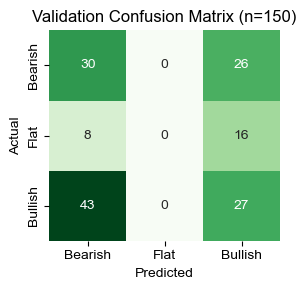

In [28]:
X_test_data = torch.FloatTensor(X_test)  # Convert features to a tensor
X_test_loader = DataLoader(X_test_data, batch_size=64, shuffle=False)
predicted_labels_test=experimental.classification_predictions(model, X_test_loader)

actual_labels_test=y_test-1
# Accuracy
accuracy = accuracy_score(actual_labels_test, predicted_labels_test)
print(f'Validation Accuracy: {round(accuracy *100, 0)} %')
print('─' * 40)

# Confusion Matrix
test_conf_matrix = confusion_matrix(actual_labels_test, predicted_labels_test)

plt.figure(figsize=(3,3))
sns.heatmap(test_conf_matrix, annot=True, cmap='Greens', cbar=False, xticklabels=['Bearish', 'Flat', 'Bullish'], yticklabels=['Bearish', 'Flat', 'Bullish'], fmt='d')

plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.title(f'Validation Confusion Matrix (n={len(X_test)})')

plt.tight_layout()
#plt.savefig('test_confusion_matrix.png', transparent=True, dpi=300)
plt.show()

Cumulative return over the period: 6937.5 %
Baseline Return (Buy and Hold over the period): 602.0 %
Maximum Drawdown Duration 202 weeks


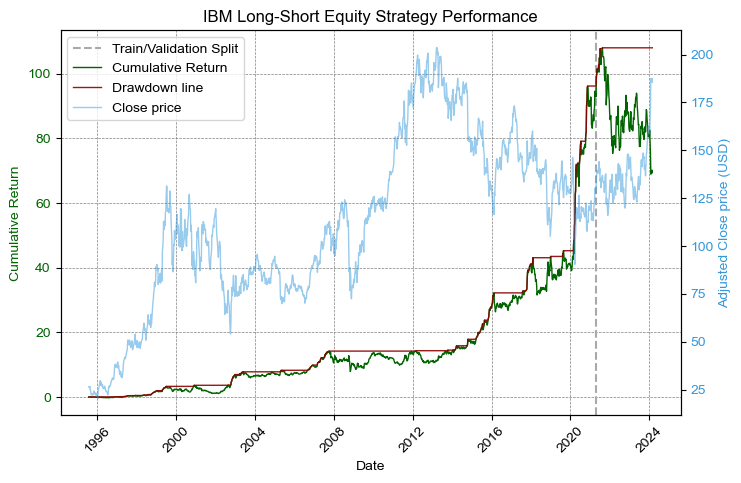

In [29]:
# Combine predictions into a single column
df['Prediction'] = np.concatenate([predicted_labels_train, predicted_labels_test])

df=utilities.calculate_returns(df, 'Prediction')

max_drawdown_duration=utilities.calculate_max_drawdown_duration(amzn)

print(f'Maximum Drawdown Duration {max_drawdown_duration} weeks')

utilities.plot_return(df, 'IBM', train_test_split=0.9, save_figure=True)

Cumulative return over the period: 22.9 %
Baseline Return (Buy and Hold over the period): 6.2 %
Validation Set Maximum Drawdown: 57 weeks


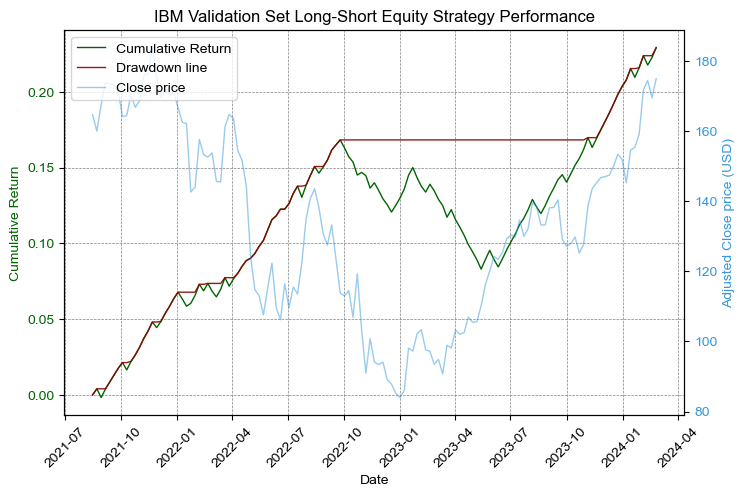

Yearly Returns and Drawdowns:
────────────────────────────────────────
Cumulative return over the period: 14.5 %
Baseline Return (Buy and Hold over the period): -14.5 %
Start Date: 2021-08-15
End Date: 2022-08-07
Maximum drawdown during the period: 4 weeks
────────────────────────────────────────
Cumulative return over the period: -1.9 %
Baseline Return (Buy and Hold over the period): -2.8 %
Start Date: 2022-08-14
End Date: 2023-08-06
Maximum drawdown during the period: 45 weeks
────────────────────────────────────────


In [30]:
split_idx=int(len(ibm)*0.9)
ibm_test_df=ibm[split_idx:]
ibm_test_df = utilities.calculate_returns(amzn_test_df, 'Prediction')
max_drawdown_duration_test = utilities.calculate_max_drawdown_duration(ibm_test_df)
print(f'Validation Set Maximum Drawdown: {max_drawdown_duration_test} weeks')
utilities.plot_return(ibm_test_df, 'IBM Validation Set', save_figure=True)
utilities.calculate_yearly_returns(ibm_test_df)

Cross-testing on MSFT Test
Cross-Test Accuracy: 43.0 %
────────────────────────────────────────
Cumulative return over the period: 29.9 %
Baseline Return (Buy and Hold over the period): 57.2 %
Maximum Drawdown Duration 25 weeks
────────────────────────────────────────


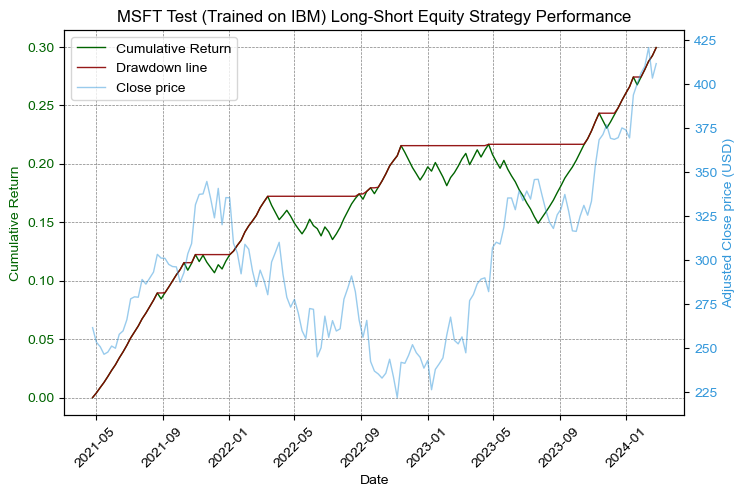

Yearly Returns and Drawdowns:
────────────────────────────────────────
Cumulative return over the period: 16.0 %
Baseline Return (Buy and Hold over the period): 6.6 %
Start Date: 2021-04-25
End Date: 2022-04-17
Maximum drawdown during the period: 9 weeks
────────────────────────────────────────
Cumulative return over the period: 4.9 %
Baseline Return (Buy and Hold over the period): 6.1 %
Start Date: 2022-04-24
End Date: 2023-04-16
Maximum drawdown during the period: 22 weeks
────────────────────────────────────────
────────────────────────────────────────────────────────────────────────────────────────────────────
Cross-testing on AMZN Test
Cross-Test Accuracy: 44.0 %
────────────────────────────────────────
Cumulative return over the period: 17.2 %
Baseline Return (Buy and Hold over the period): 6.2 %
Maximum Drawdown Duration 48 weeks
────────────────────────────────────────


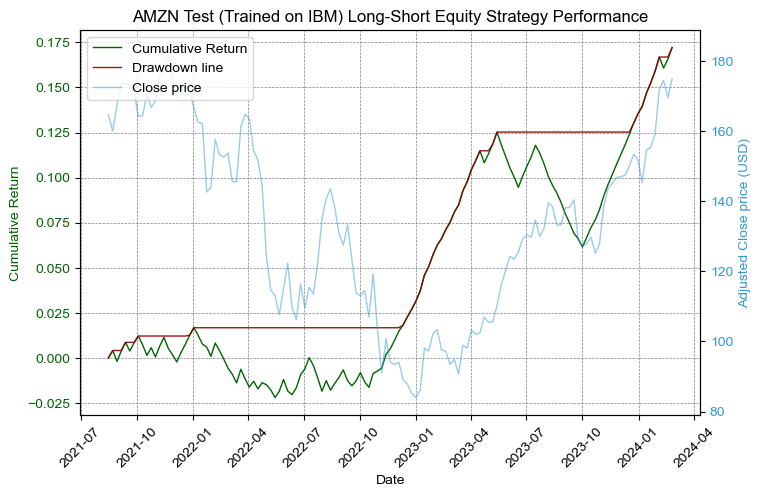

Yearly Returns and Drawdowns:
────────────────────────────────────────
Cumulative return over the period: -1.3 %
Baseline Return (Buy and Hold over the period): -14.5 %
Start Date: 2021-08-15
End Date: 2022-08-07
Maximum drawdown during the period: 31 weeks
────────────────────────────────────────
Cumulative return over the period: 12.1 %
Baseline Return (Buy and Hold over the period): -2.8 %
Start Date: 2022-08-14
End Date: 2023-08-06
Maximum drawdown during the period: 12 weeks
────────────────────────────────────────
────────────────────────────────────────────────────────────────────────────────────────────────────
Cross-testing on S&P500 Test
Cross-Test Accuracy: 44.0 %
────────────────────────────────────────
Cumulative return over the period: 21.9 %
Baseline Return (Buy and Hold over the period): 21.7 %
Maximum Drawdown Duration 45 weeks
────────────────────────────────────────


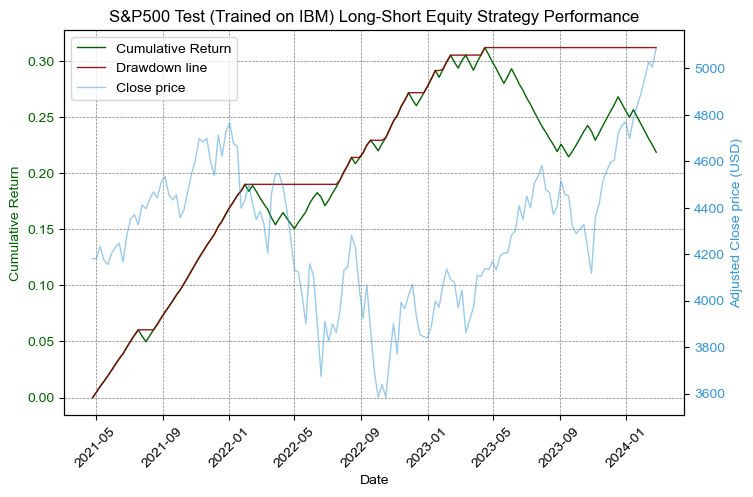

Yearly Returns and Drawdowns:
────────────────────────────────────────
Cumulative return over the period: 16.0 %
Baseline Return (Buy and Hold over the period): 5.1 %
Start Date: 2021-04-25
End Date: 2022-04-17
Maximum drawdown during the period: 11 weeks
────────────────────────────────────────
Cumulative return over the period: 13.6 %
Baseline Return (Buy and Hold over the period): -3.1 %
Start Date: 2022-04-24
End Date: 2023-04-16
Maximum drawdown during the period: 4 weeks
────────────────────────────────────────
────────────────────────────────────────────────────────────────────────────────────────────────────
Cross-testing on NASDAQ Test
Cross-Test Accuracy: 44.0 %
────────────────────────────────────────
Cumulative return over the period: 22.6 %
Baseline Return (Buy and Hold over the period): 14.1 %
Maximum Drawdown Duration 45 weeks
────────────────────────────────────────


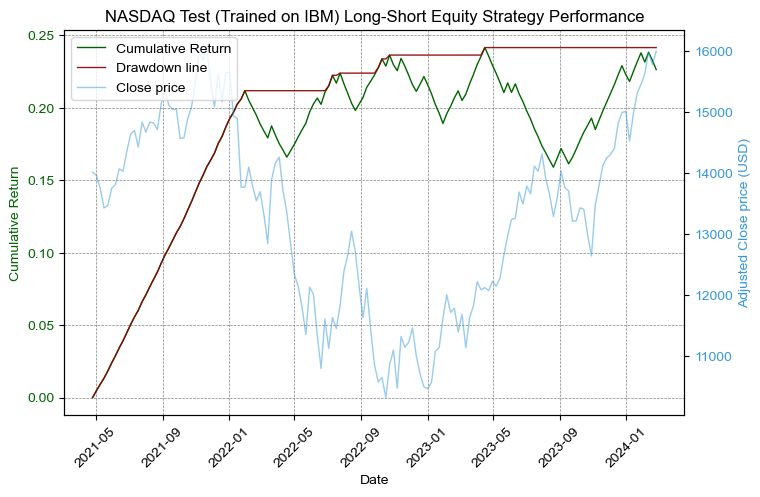

Yearly Returns and Drawdowns:
────────────────────────────────────────
Cumulative return over the period: 16.6 %
Baseline Return (Buy and Hold over the period): -4.7 %
Start Date: 2021-04-25
End Date: 2022-04-17
Maximum drawdown during the period: 11 weeks
────────────────────────────────────────
Cumulative return over the period: 6.1 %
Baseline Return (Buy and Hold over the period): -5.6 %
Start Date: 2022-04-24
End Date: 2023-04-16
Maximum drawdown during the period: 24 weeks
────────────────────────────────────────
────────────────────────────────────────────────────────────────────────────────────────────────────
Cross-testing on CAC Test
Cross-Test Accuracy: 44.0 %
────────────────────────────────────────
Cumulative return over the period: 9.3 %
Baseline Return (Buy and Hold over the period): 27.3 %
Maximum Drawdown Duration 68 weeks
────────────────────────────────────────


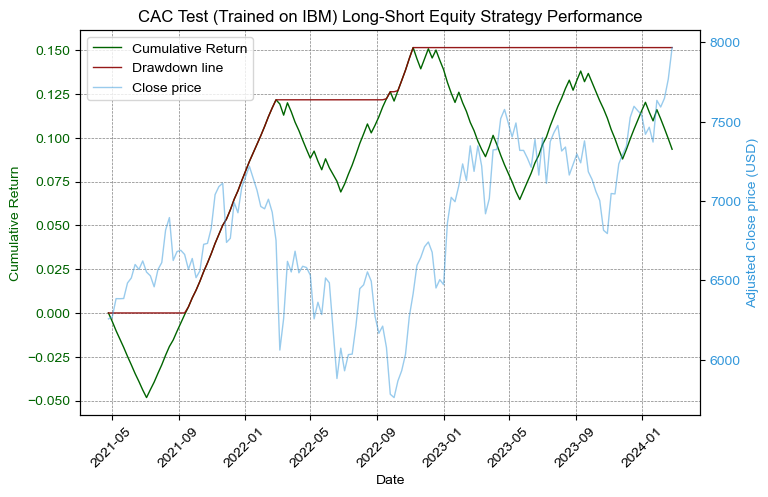

Yearly Returns and Drawdowns:
────────────────────────────────────────
Cumulative return over the period: 9.9 %
Baseline Return (Buy and Hold over the period): 5.3 %
Start Date: 2021-04-25
End Date: 2022-04-17
Maximum drawdown during the period: 20 weeks
────────────────────────────────────────
Cumulative return over the period: -0.3 %
Baseline Return (Buy and Hold over the period): 14.3 %
Start Date: 2022-04-24
End Date: 2023-04-16
Maximum drawdown during the period: 23 weeks
────────────────────────────────────────
────────────────────────────────────────────────────────────────────────────────────────────────────


In [31]:
# Defining and preparing the dataframe subsets to use for cross-testing models
def prepare_test_df(df, name):
    split_idx = int(len(df) * 0.9)
    test_df = df.iloc[split_idx:].drop(columns=['Open', 'High', 'Low']).copy()
    
    # Apply the MinMaxScaler, fitted on the dataset that the model was trained on
    features = test_df[feature_columns]
    scaled_features = scaler.transform(features)
    
    # Store the scaled features back into the DataFrame
    test_df[feature_columns] = scaled_features
    
    return test_df, name

# Prepare each DataFrame
msft_test_df, msft_name = prepare_test_df(msft, 'MSFT Test')
amzn_test_df, amzn_name = prepare_test_df(amzn, 'AMZN Test')
sp500_test_df, sp500_name = prepare_test_df(sp500, 'S&P500 Test')
nasdaq_test_df, nasdaq_name = prepare_test_df(nasdaq, 'NASDAQ Test')
cac_test_df, cac_name = prepare_test_df(cac, 'CAC Test')

# Create a dictionary for better readability and access
test_dfs = {
    msft_name: msft_test_df,
    amzn_name: amzn_test_df,
    sp500_name: sp500_test_df,
    nasdaq_name: nasdaq_test_df,
    cac_name: cac_test_df
}
    
for df_name, df in test_dfs.items():

    actual_labels_test = df['Next_week_market_behavior']
    
    X_test = df[feature_columns].values
    
    X_test_data = torch.FloatTensor(X_test)  # Convert features to a tensor
    X_test_loader = DataLoader(X_test_data, batch_size=64, shuffle=False)

    predicted_labels_test=experimental.classification_predictions(model, X_test_loader)

    print(f'Cross-testing on {df_name}')
    # Accuracy
    accuracy = accuracy_score(actual_labels_test, predicted_labels_test)
    print(f'Cross-Test Accuracy: {round(accuracy *100, 0)} %')
    print('─' * 40)

    # Returns
    df['Prediction'] = predicted_labels_test

    df=utilities.calculate_returns(df, 'Prediction')
    
    max_drawdown_duration=utilities.calculate_max_drawdown_duration(df)
    
    print(f'Maximum Drawdown Duration {max_drawdown_duration} weeks')
    print('─' * 40) 

    utilities.plot_return(df, df_name+' (Trained on IBM)', save_figure=True)

    utilities.calculate_yearly_returns(df)

    print('─' * 100)

***
## CAC dataset

### Training for 500 epochs, training size = 1341 cases
epoch    0: Loss=1.16751
epoch   10: Loss=1.03546
epoch   20: Loss=1.02378
epoch   30: Loss=1.01570
epoch   40: Loss=1.00611
epoch   50: Loss=1.00311
epoch   60: Loss=1.00225
epoch   70: Loss=1.00326
epoch   80: Loss=1.00089
epoch   90: Loss=0.99794
epoch  100: Loss=0.99495
epoch  110: Loss=0.99230
epoch  120: Loss=0.98992
epoch  130: Loss=0.98793
epoch  140: Loss=0.98622
epoch  150: Loss=0.98468
epoch  160: Loss=0.98323
epoch  170: Loss=0.98182
epoch  180: Loss=0.98040
epoch  190: Loss=0.97899
epoch  200: Loss=0.97761
epoch  210: Loss=0.97632
epoch  220: Loss=0.97516
epoch  230: Loss=0.97410
epoch  240: Loss=0.97313
epoch  250: Loss=0.97224
epoch  260: Loss=0.97141
epoch  270: Loss=0.97065
epoch  280: Loss=0.96996
epoch  290: Loss=0.96935
epoch  300: Loss=0.96881
epoch  310: Loss=0.96834
epoch  320: Loss=0.96792
epoch  330: Loss=0.96756
epoch  340: Loss=0.96724
epoch  350: Loss=0.96696
epoch  360: Loss=0.96670
epoch  370: Loss=0.

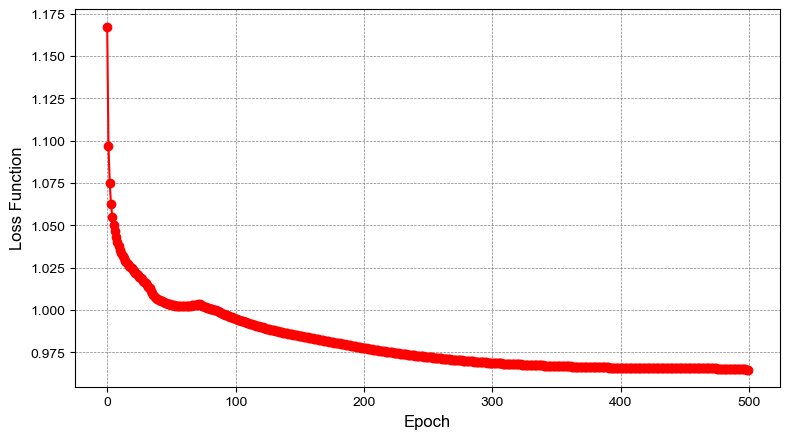

In [32]:
df=cac
    
# Now let's prepare the features
features = df[feature_columns]
scaler = MinMaxScaler()
features = scaler.fit_transform(features)

# Prepare the target to fit the labeling used by pytorch {0,1,2}
target = df['Next_week_market_behavior']+1

# Calculate the index for the split
split_idx = int(len(features) * 0.9)

# Split the features and target into training/testing sets without shuffling
X_train = features[:split_idx]
X_test = features[split_idx:]
y_train = target.iloc[:split_idx]
y_test = target.iloc[split_idx:]

# Convert to PyTorch tensors
train_data = TensorDataset(torch.FloatTensor(X_train), torch.LongTensor(y_train.values))
test_data = TensorDataset(torch.FloatTensor(X_test), torch.LongTensor(y_test.values))

# Create Data Loaders
train_loader = DataLoader(train_data, batch_size=64, shuffle=False)  # Usually, you don't shuffle time series data
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

optimizer = torch.optim.Adam(model.parameters())
experimental.train_anfis_classifier_with(model=model, 
                                         data=train_loader, 
                                         optimizer=optimizer, 
                                         epochs=500, 
                                         show_plots=True)

Training Accuracy: 49.0 %
────────────────────────────────────────


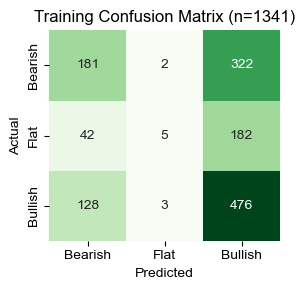

In [33]:
X_train_data = torch.FloatTensor(X_train)  # Convert features to a tensor
X_train_loader = DataLoader(X_train_data, batch_size=64, shuffle=False)
predicted_labels_train =experimental.classification_predictions(model, X_train_loader)

actual_labels_train =y_train-1
# Accuracy
accuracy = accuracy_score(actual_labels_train, predicted_labels_train)
print(f'Training Accuracy: {round(accuracy *100, 0)} %')
print('─' * 40)

# Confusion Matrix
train_conf_matrix = confusion_matrix(actual_labels_train, predicted_labels_train)

plt.figure(figsize=(3,3))
sns.heatmap(train_conf_matrix, annot=True, cmap='Greens', cbar=False, xticklabels=['Bearish', 'Flat', 'Bullish'], yticklabels=['Bearish', 'Flat', 'Bullish'], fmt='d')

plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.title(f'Training Confusion Matrix (n={len(X_train)})')

plt.tight_layout()
#plt.savefig('training_confusion_matrix.png', transparent=True, dpi=300)
plt.show()

Validation Accuracy: 44.0 %
────────────────────────────────────────


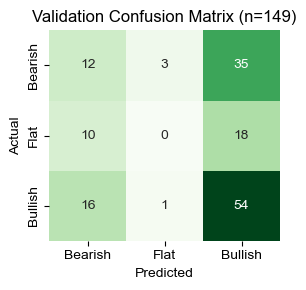

In [34]:
X_test_data = torch.FloatTensor(X_test)  # Convert features to a tensor
X_test_loader = DataLoader(X_test_data, batch_size=64, shuffle=False)
predicted_labels_test=experimental.classification_predictions(model, X_test_loader)

actual_labels_test=y_test-1
# Accuracy
accuracy = accuracy_score(actual_labels_test, predicted_labels_test)
print(f'Validation Accuracy: {round(accuracy *100, 0)} %')
print('─' * 40)

# Confusion Matrix
test_conf_matrix = confusion_matrix(actual_labels_test, predicted_labels_test)

plt.figure(figsize=(3,3))
sns.heatmap(test_conf_matrix, annot=True, cmap='Greens', cbar=False, xticklabels=['Bearish', 'Flat', 'Bullish'], yticklabels=['Bearish', 'Flat', 'Bullish'], fmt='d')

plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.title(f'Validation Confusion Matrix (n={len(X_test)})')

plt.tight_layout()
#plt.savefig('test_confusion_matrix.png', transparent=True, dpi=300)
plt.show()

Cumulative return over the period: 18105.9 %
Baseline Return (Buy and Hold over the period): 309.3 %
Maximum Drawdown Duration 202 weeks


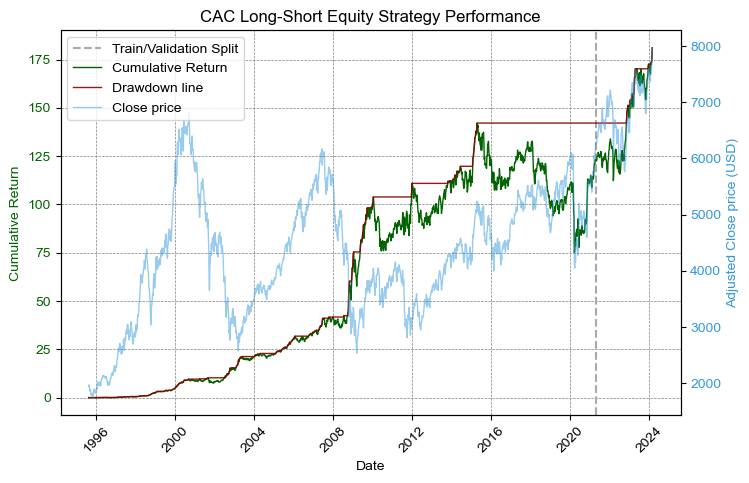

In [35]:
# Combine predictions into a single column
df['Prediction'] = np.concatenate([predicted_labels_train, predicted_labels_test])

df=utilities.calculate_returns(df, 'Prediction')

max_drawdown_duration=utilities.calculate_max_drawdown_duration(amzn)

print(f'Maximum Drawdown Duration {max_drawdown_duration} weeks')

utilities.plot_return(df, 'CAC', train_test_split=0.9, save_figure=True)

Cumulative return over the period: 47.4 %
Baseline Return (Buy and Hold over the period): 27.3 %
Validation Set Maximum Drawdown: 40 weeks


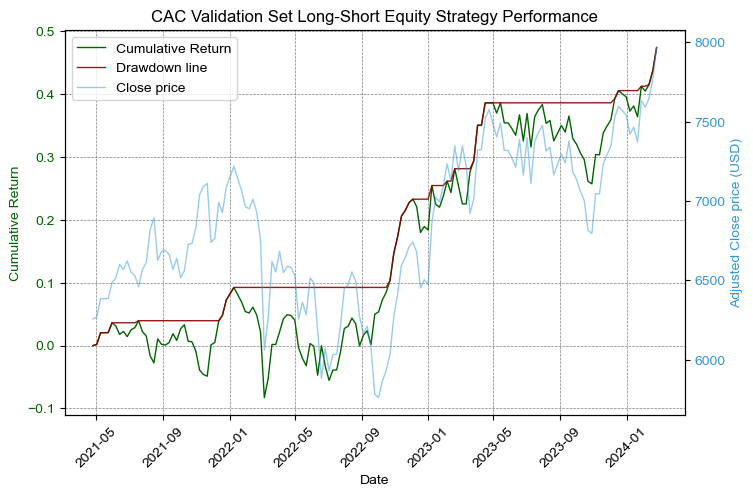

Yearly Returns and Drawdowns:
────────────────────────────────────────
Cumulative return over the period: 4.9 %
Baseline Return (Buy and Hold over the period): 5.3 %
Start Date: 2021-04-25
End Date: 2022-04-17
Maximum drawdown during the period: 21 weeks
────────────────────────────────────────
Cumulative return over the period: 32.3 %
Baseline Return (Buy and Hold over the period): 14.3 %
Start Date: 2022-04-24
End Date: 2023-04-16
Maximum drawdown during the period: 21 weeks
────────────────────────────────────────


In [36]:
split_idx=int(len(cac)*0.9)
cac_test_df=cac[split_idx:]
cac_test_df = utilities.calculate_returns(cac_test_df, 'Prediction')
max_drawdown_duration_test = utilities.calculate_max_drawdown_duration(cac_test_df)
print(f'Validation Set Maximum Drawdown: {max_drawdown_duration_test} weeks')
utilities.plot_return(cac_test_df, 'CAC Validation Set', save_figure=True)
utilities.calculate_yearly_returns(cac_test_df)

Cross-testing on MSFT Test
Cross-Test Accuracy: 41.0 %
────────────────────────────────────────
Cumulative return over the period: -10.4 %
Baseline Return (Buy and Hold over the period): 57.2 %
Maximum Drawdown Duration 133 weeks
────────────────────────────────────────


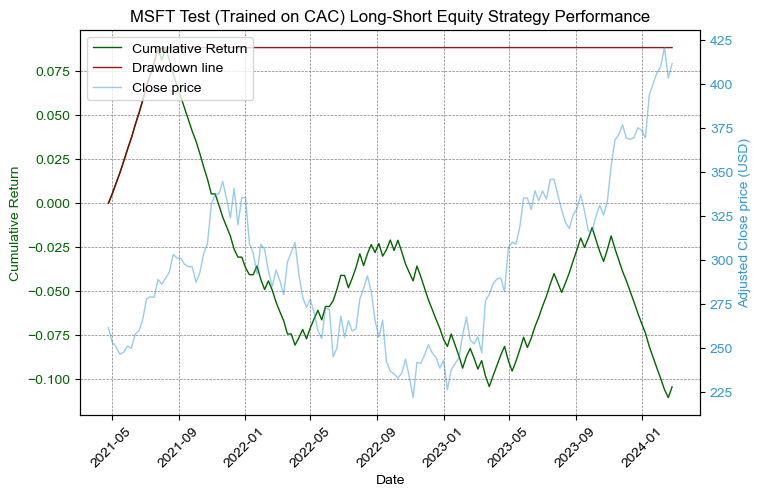

Yearly Returns and Drawdowns:
────────────────────────────────────────
Cumulative return over the period: -7.2 %
Baseline Return (Buy and Hold over the period): 6.6 %
Start Date: 2021-04-25
End Date: 2022-04-17
Maximum drawdown during the period: 36 weeks
────────────────────────────────────────
Cumulative return over the period: -1.0 %
Baseline Return (Buy and Hold over the period): 6.1 %
Start Date: 2022-04-24
End Date: 2023-04-16
Maximum drawdown during the period: 29 weeks
────────────────────────────────────────
────────────────────────────────────────────────────────────────────────────────────────────────────
Cross-testing on AMZN Test
Cross-Test Accuracy: 44.0 %
────────────────────────────────────────
Cumulative return over the period: 4.2 %
Baseline Return (Buy and Hold over the period): 6.2 %
Maximum Drawdown Duration 88 weeks
────────────────────────────────────────


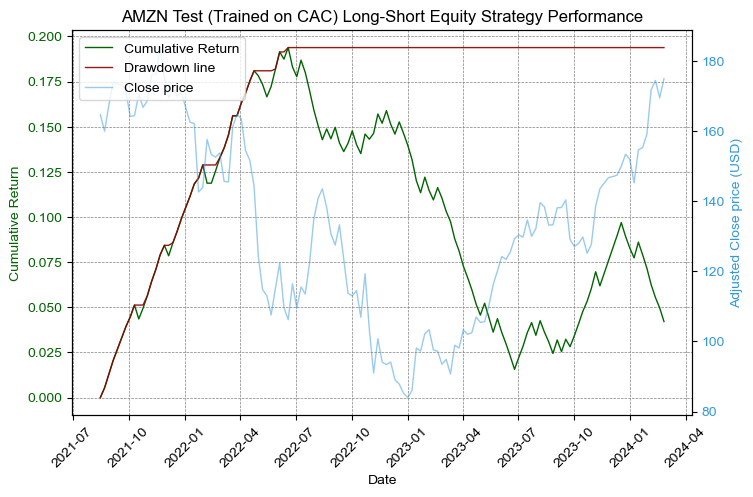

Yearly Returns and Drawdowns:
────────────────────────────────────────
Cumulative return over the period: 15.1 %
Baseline Return (Buy and Hold over the period): -14.5 %
Start Date: 2021-08-15
End Date: 2022-08-07
Maximum drawdown during the period: 7 weeks
────────────────────────────────────────
Cumulative return over the period: -8.8 %
Baseline Return (Buy and Hold over the period): -2.8 %
Start Date: 2022-08-14
End Date: 2023-08-06
Maximum drawdown during the period: 36 weeks
────────────────────────────────────────
────────────────────────────────────────────────────────────────────────────────────────────────────
Cross-testing on S&P500 Test
Cross-Test Accuracy: 42.0 %
────────────────────────────────────────
Cumulative return over the period: 29.5 %
Baseline Return (Buy and Hold over the period): 21.7 %
Maximum Drawdown Duration 103 weeks
────────────────────────────────────────


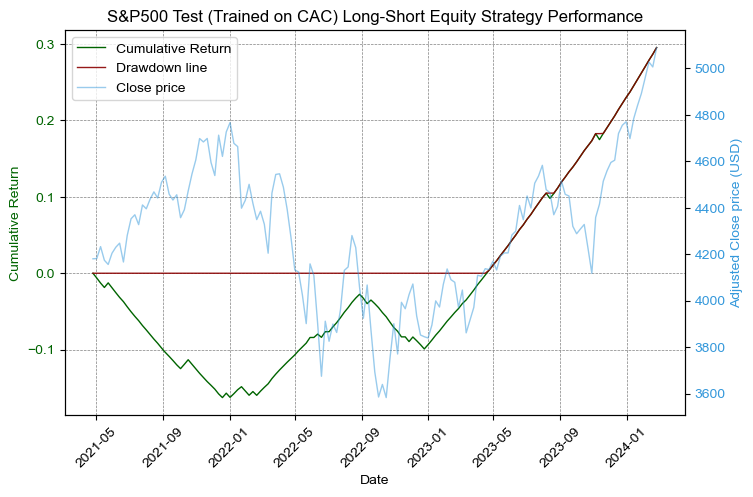

Yearly Returns and Drawdowns:
────────────────────────────────────────
Cumulative return over the period: -11.6 %
Baseline Return (Buy and Hold over the period): 5.1 %
Start Date: 2021-04-25
End Date: 2022-04-17
Maximum drawdown during the period: 51 weeks
────────────────────────────────────────
Cumulative return over the period: 12.3 %
Baseline Return (Buy and Hold over the period): -3.1 %
Start Date: 2022-04-24
End Date: 2023-04-16
Maximum drawdown during the period: 29 weeks
────────────────────────────────────────
────────────────────────────────────────────────────────────────────────────────────────────────────
Cross-testing on NASDAQ Test
Cross-Test Accuracy: 46.0 %
────────────────────────────────────────
Cumulative return over the period: 38.3 %
Baseline Return (Buy and Hold over the period): 14.1 %
Maximum Drawdown Duration 63 weeks
────────────────────────────────────────


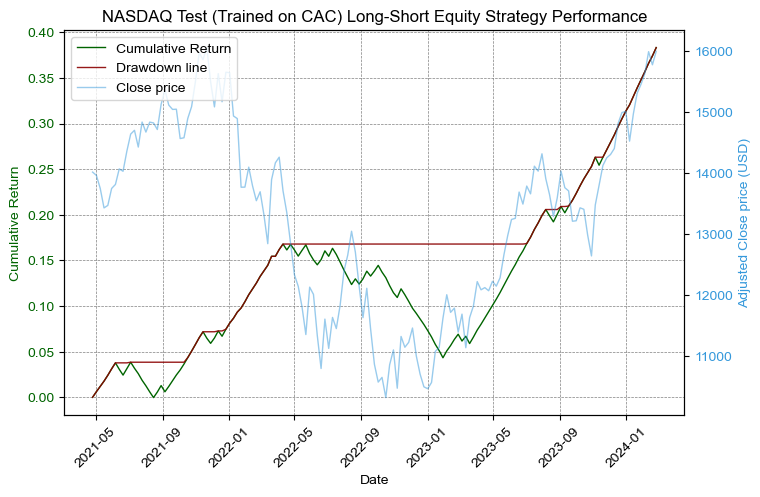

Yearly Returns and Drawdowns:
────────────────────────────────────────
Cumulative return over the period: 16.2 %
Baseline Return (Buy and Hold over the period): -4.7 %
Start Date: 2021-04-25
End Date: 2022-04-17
Maximum drawdown during the period: 14 weeks
────────────────────────────────────────
Cumulative return over the period: -6.9 %
Baseline Return (Buy and Hold over the period): -5.6 %
Start Date: 2022-04-24
End Date: 2023-04-16
Maximum drawdown during the period: 51 weeks
────────────────────────────────────────
────────────────────────────────────────────────────────────────────────────────────────────────────
Cross-testing on IBM Test
Cross-Test Accuracy: 41.0 %
────────────────────────────────────────
Cumulative return over the period: 87.7 %
Baseline Return (Buy and Hold over the period): 45.3 %
Maximum Drawdown Duration 7 weeks
────────────────────────────────────────


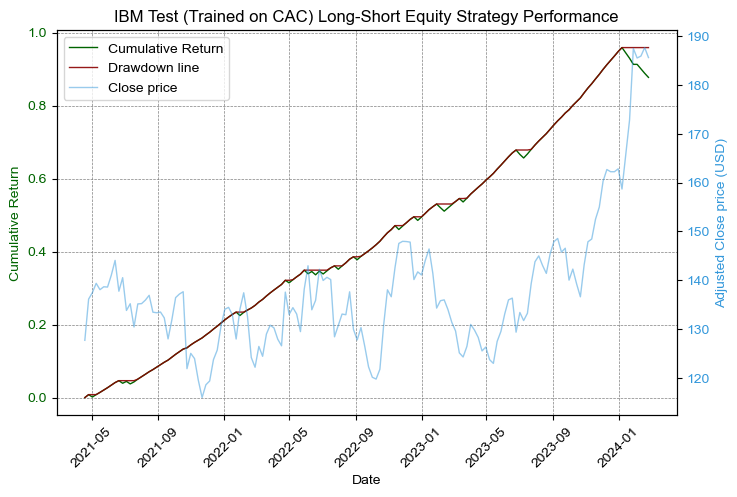

Yearly Returns and Drawdowns:
────────────────────────────────────────
Cumulative return over the period: 30.2 %
Baseline Return (Buy and Hold over the period): 0.2 %
Start Date: 2021-04-18
End Date: 2022-04-10
Maximum drawdown during the period: 4 weeks
────────────────────────────────────────
Cumulative return over the period: 19.6 %
Baseline Return (Buy and Hold over the period): 2.6 %
Start Date: 2022-04-17
End Date: 2023-04-09
Maximum drawdown during the period: 6 weeks
────────────────────────────────────────
────────────────────────────────────────────────────────────────────────────────────────────────────


In [37]:
# Defining and preparing the dataframe subsets to use for cross-testing models
def prepare_test_df(df, name):
    split_idx = int(len(df) * 0.9)
    test_df = df.iloc[split_idx:].drop(columns=['Open', 'High', 'Low']).copy()
    
    # Apply the MinMaxScaler, fitted on the dataset that the model was trained on
    features = test_df[feature_columns]
    scaled_features = scaler.transform(features)
    
    # Store the scaled features back into the DataFrame
    test_df[feature_columns] = scaled_features
    
    return test_df, name

# Prepare each DataFrame
msft_test_df, msft_name = prepare_test_df(msft, 'MSFT Test')
amzn_test_df, amzn_name = prepare_test_df(amzn, 'AMZN Test')
sp500_test_df, sp500_name = prepare_test_df(sp500, 'S&P500 Test')
nasdaq_test_df, nasdaq_name = prepare_test_df(nasdaq, 'NASDAQ Test')
ibm_test_df, ibm_name = prepare_test_df(ibm, 'IBM Test')

# Create a dictionary for better readability and access
test_dfs = {
    msft_name: msft_test_df,
    amzn_name: amzn_test_df,
    sp500_name: sp500_test_df,
    nasdaq_name: nasdaq_test_df,
    ibm_name: ibm_test_df
}
    
for df_name, df in test_dfs.items():

    actual_labels_test = df['Next_week_market_behavior']
    
    X_test = df[feature_columns].values
    
    X_test_data = torch.FloatTensor(X_test)  # Convert features to a tensor
    X_test_loader = DataLoader(X_test_data, batch_size=64, shuffle=False)

    predicted_labels_test=experimental.classification_predictions(model, X_test_loader)

    print(f'Cross-testing on {df_name}')
    # Accuracy
    accuracy = accuracy_score(actual_labels_test, predicted_labels_test)
    print(f'Cross-Test Accuracy: {round(accuracy *100, 0)} %')
    print('─' * 40)

    # Returns
    df['Prediction'] = predicted_labels_test

    df=utilities.calculate_returns(df, 'Prediction')
    
    max_drawdown_duration=utilities.calculate_max_drawdown_duration(df)
    
    print(f'Maximum Drawdown Duration {max_drawdown_duration} weeks')
    print('─' * 40) 

    utilities.plot_return(df, df_name+' (Trained on CAC)', save_figure=True)

    utilities.calculate_yearly_returns(df)

    print('─' * 100)

***
## S&P500 dataset

### Training for 500 epochs, training size = 1339 cases
epoch    0: Loss=1.17121
epoch   10: Loss=1.03759
epoch   20: Loss=1.02369
epoch   30: Loss=1.02068
epoch   40: Loss=1.02011
epoch   50: Loss=1.01744
epoch   60: Loss=1.01763
epoch   70: Loss=1.01628
epoch   80: Loss=1.01432
epoch   90: Loss=1.01284
epoch  100: Loss=1.01296
epoch  110: Loss=1.01257
epoch  120: Loss=1.01058
epoch  130: Loss=1.01038
epoch  140: Loss=1.01083
epoch  150: Loss=1.00907
epoch  160: Loss=1.01152
epoch  170: Loss=1.00836
epoch  180: Loss=1.01131
epoch  190: Loss=1.01090
epoch  200: Loss=1.01055
epoch  210: Loss=1.01024
epoch  220: Loss=1.00995
epoch  230: Loss=1.00967
epoch  240: Loss=1.00942
epoch  250: Loss=1.00917
epoch  260: Loss=1.00892
epoch  270: Loss=1.00867
epoch  280: Loss=1.00844
epoch  290: Loss=1.00820
epoch  300: Loss=1.00797
epoch  310: Loss=1.00774
epoch  320: Loss=1.00752
epoch  330: Loss=1.00730
epoch  340: Loss=1.00708
epoch  350: Loss=1.00687
epoch  360: Loss=1.00666
epoch  370: Loss=1.

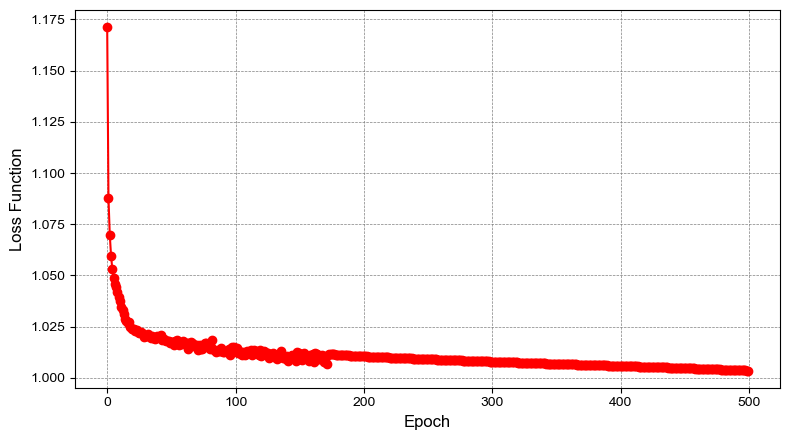

In [38]:
df=sp500
    
# Now let's prepare the features
features = df[feature_columns]
scaler = MinMaxScaler()
features = scaler.fit_transform(features)

# Prepare the target to fit the labeling used by pytorch {0,1,2}
target = df['Next_week_market_behavior']+1

# Calculate the index for the split
split_idx = int(len(features) * 0.9)

# Split the features and target into training/testing sets without shuffling
X_train = features[:split_idx]
X_test = features[split_idx:]
y_train = target.iloc[:split_idx]
y_test = target.iloc[split_idx:]

# Convert to PyTorch tensors
train_data = TensorDataset(torch.FloatTensor(X_train), torch.LongTensor(y_train.values))
test_data = TensorDataset(torch.FloatTensor(X_test), torch.LongTensor(y_test.values))

# Create Data Loaders
train_loader = DataLoader(train_data, batch_size=64, shuffle=False)  # Usually, you don't shuffle time series data
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

optimizer = torch.optim.Adam(model.parameters())
experimental.train_anfis_classifier_with(model=model, 
                                         data=train_loader, 
                                         optimizer=optimizer, 
                                         epochs=500, 
                                         show_plots=True)

Training Accuracy: 48.0 %
────────────────────────────────────────


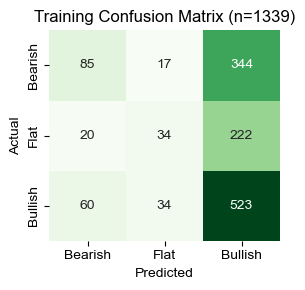

In [39]:
X_train_data = torch.FloatTensor(X_train)  # Convert features to a tensor
X_train_loader = DataLoader(X_train_data, batch_size=64, shuffle=False)
predicted_labels_train =experimental.classification_predictions(model, X_train_loader)

actual_labels_train =y_train-1
# Accuracy
accuracy = accuracy_score(actual_labels_train, predicted_labels_train)
print(f'Training Accuracy: {round(accuracy *100, 0)} %')
print('─' * 40)

# Confusion Matrix
train_conf_matrix = confusion_matrix(actual_labels_train, predicted_labels_train)

plt.figure(figsize=(3,3))
sns.heatmap(train_conf_matrix, annot=True, cmap='Greens', cbar=False, xticklabels=['Bearish', 'Flat', 'Bullish'], yticklabels=['Bearish', 'Flat', 'Bullish'], fmt='d')

plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.title(f'Training Confusion Matrix (n={len(X_train)})')

plt.tight_layout()
#plt.savefig('training_confusion_matrix.png', transparent=True, dpi=300)
plt.show()

Validation Accuracy: 44.0 %
────────────────────────────────────────


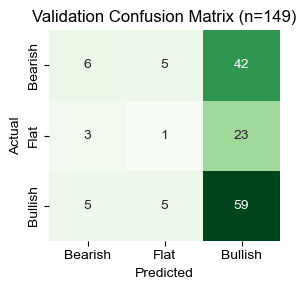

In [40]:
X_test_data = torch.FloatTensor(X_test)  # Convert features to a tensor
X_test_loader = DataLoader(X_test_data, batch_size=64, shuffle=False)
predicted_labels_test=experimental.classification_predictions(model, X_test_loader)

actual_labels_test=y_test-1
# Accuracy
accuracy = accuracy_score(actual_labels_test, predicted_labels_test)
print(f'Validation Accuracy: {round(accuracy *100, 0)} %')
print('─' * 40)

# Confusion Matrix
test_conf_matrix = confusion_matrix(actual_labels_test, predicted_labels_test)

plt.figure(figsize=(3,3))
sns.heatmap(test_conf_matrix, annot=True, cmap='Greens', cbar=False, xticklabels=['Bearish', 'Flat', 'Bullish'], yticklabels=['Bearish', 'Flat', 'Bullish'], fmt='d')

plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.title(f'Validation Confusion Matrix (n={len(X_test)})')

plt.tight_layout()
#plt.savefig('test_confusion_matrix.png', transparent=True, dpi=300)
plt.show()

Cumulative return over the period: 7691.7 %
Baseline Return (Buy and Hold over the period): 808.6 %
Maximum Drawdown Duration 202 weeks


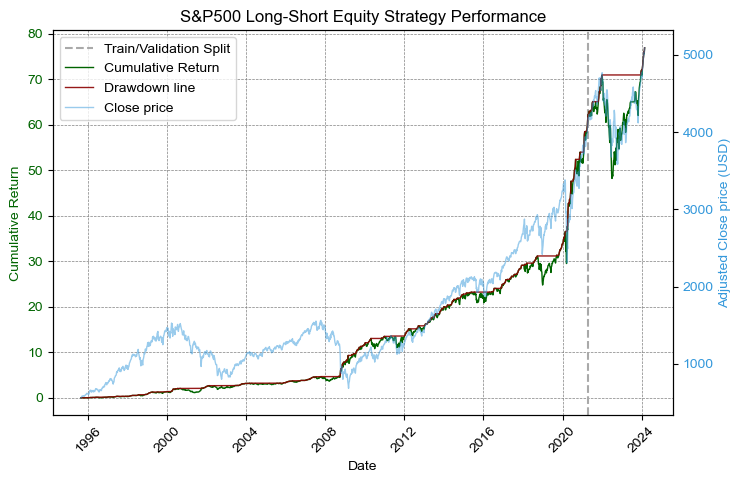

In [41]:
# Combine predictions into a single column
df['Prediction'] = np.concatenate([predicted_labels_train, predicted_labels_test])

df=utilities.calculate_returns(df, 'Prediction')

max_drawdown_duration=utilities.calculate_max_drawdown_duration(amzn)

print(f'Maximum Drawdown Duration {max_drawdown_duration} weeks')

utilities.plot_return(df, 'S&P500', train_test_split=0.9, save_figure=True)

Cumulative return over the period: 23.3 %
Baseline Return (Buy and Hold over the period): 21.7 %
Validation Set Maximum Drawdown: 101 weeks


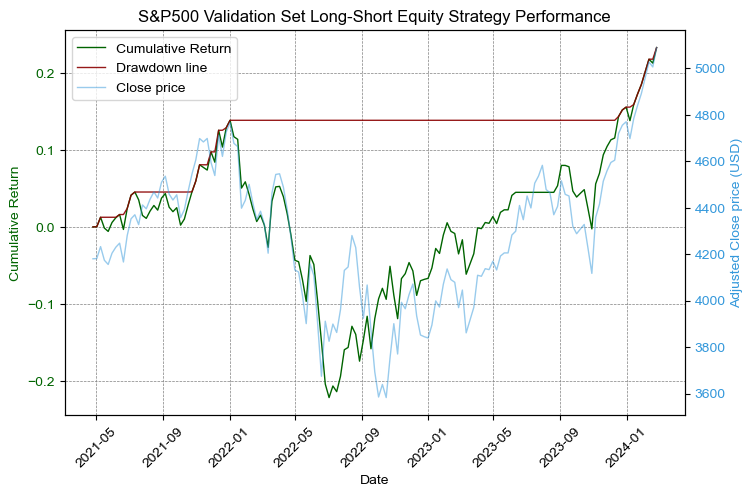

Yearly Returns and Drawdowns:
────────────────────────────────────────
Cumulative return over the period: 1.7 %
Baseline Return (Buy and Hold over the period): 5.1 %
Start Date: 2021-04-25
End Date: 2022-04-17
Maximum drawdown during the period: 15 weeks
────────────────────────────────────────
Cumulative return over the period: 1.7 %
Baseline Return (Buy and Hold over the period): -3.1 %
Start Date: 2022-04-24
End Date: 2023-04-16
Maximum drawdown during the period: 39 weeks
────────────────────────────────────────


In [42]:
split_idx=int(len(sp500)*0.9)
sp500_test_df=sp500[split_idx:]
sp500_test_df = utilities.calculate_returns(sp500_test_df, 'Prediction')
max_drawdown_duration_test = utilities.calculate_max_drawdown_duration(sp500_test_df)
print(f'Validation Set Maximum Drawdown: {max_drawdown_duration_test} weeks')
utilities.plot_return(sp500_test_df, 'S&P500 Validation Set', save_figure=True)
utilities.calculate_yearly_returns(sp500_test_df)

Cross-testing on MSFT Test
Cross-Test Accuracy: 46.0 %
────────────────────────────────────────
Cumulative return over the period: 33.4 %
Baseline Return (Buy and Hold over the period): 57.2 %
Maximum Drawdown Duration 56 weeks
────────────────────────────────────────


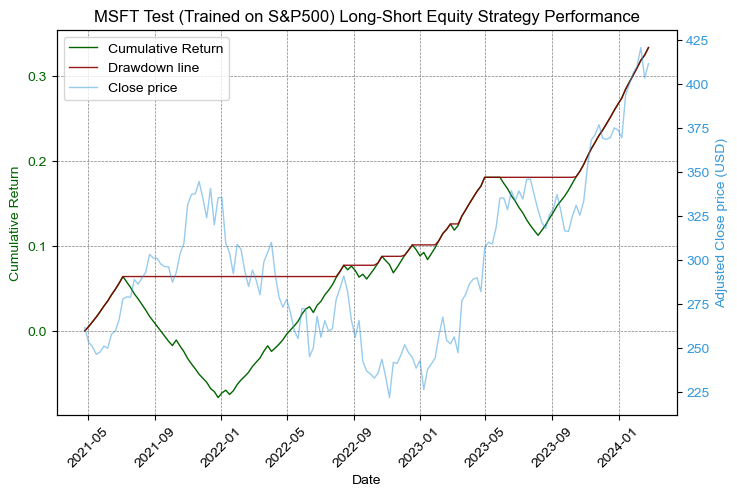

Yearly Returns and Drawdowns:
────────────────────────────────────────
Cumulative return over the period: -1.6 %
Baseline Return (Buy and Hold over the period): 6.6 %
Start Date: 2021-04-25
End Date: 2022-04-17
Maximum drawdown during the period: 41 weeks
────────────────────────────────────────
Cumulative return over the period: 17.7 %
Baseline Return (Buy and Hold over the period): 6.1 %
Start Date: 2022-04-24
End Date: 2023-04-16
Maximum drawdown during the period: 8 weeks
────────────────────────────────────────
────────────────────────────────────────────────────────────────────────────────────────────────────
Cross-testing on AMZN Test
Cross-Test Accuracy: 53.0 %
────────────────────────────────────────
Cumulative return over the period: 75.8 %
Baseline Return (Buy and Hold over the period): 6.2 %
Maximum Drawdown Duration 8 weeks
────────────────────────────────────────


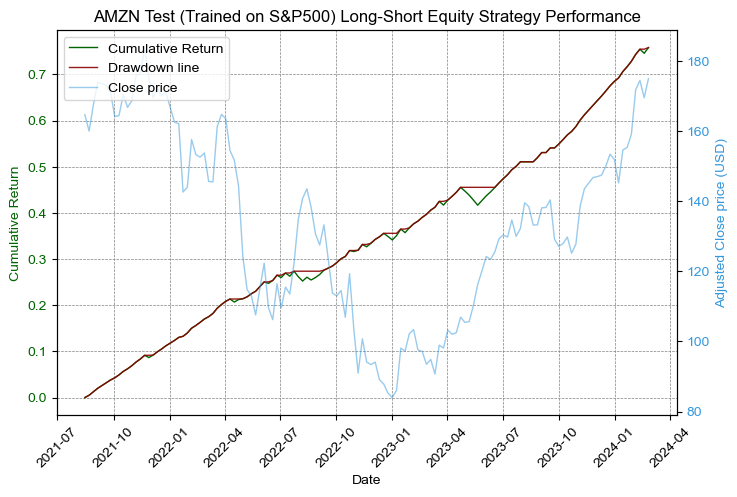

Yearly Returns and Drawdowns:
────────────────────────────────────────
Cumulative return over the period: 25.2 %
Baseline Return (Buy and Hold over the period): -14.5 %
Start Date: 2021-08-15
End Date: 2022-08-07
Maximum drawdown during the period: 2 weeks
────────────────────────────────────────
Cumulative return over the period: 19.8 %
Baseline Return (Buy and Hold over the period): -2.8 %
Start Date: 2022-08-14
End Date: 2023-08-06
Maximum drawdown during the period: 8 weeks
────────────────────────────────────────
────────────────────────────────────────────────────────────────────────────────────────────────────
Cross-testing on CAC Test
Cross-Test Accuracy: 46.0 %
────────────────────────────────────────
Cumulative return over the period: 113.5 %
Baseline Return (Buy and Hold over the period): 27.3 %
Maximum Drawdown Duration 7 weeks
────────────────────────────────────────


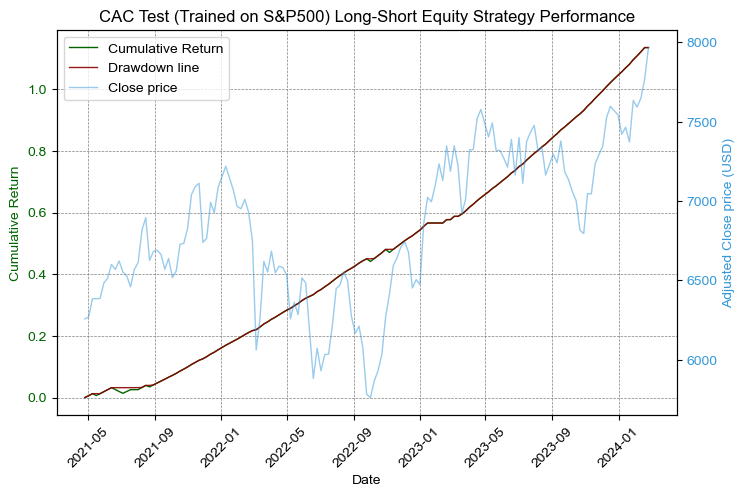

Yearly Returns and Drawdowns:
────────────────────────────────────────
Cumulative return over the period: 26.8 %
Baseline Return (Buy and Hold over the period): 5.3 %
Start Date: 2021-04-25
End Date: 2022-04-17
Maximum drawdown during the period: 7 weeks
────────────────────────────────────────
Cumulative return over the period: 28.4 %
Baseline Return (Buy and Hold over the period): 14.3 %
Start Date: 2022-04-24
End Date: 2023-04-16
Maximum drawdown during the period: 1 weeks
────────────────────────────────────────
────────────────────────────────────────────────────────────────────────────────────────────────────
Cross-testing on NASDAQ Test
Cross-Test Accuracy: 44.0 %
────────────────────────────────────────
Cumulative return over the period: 85.3 %
Baseline Return (Buy and Hold over the period): 14.1 %
Maximum Drawdown Duration 31 weeks
────────────────────────────────────────


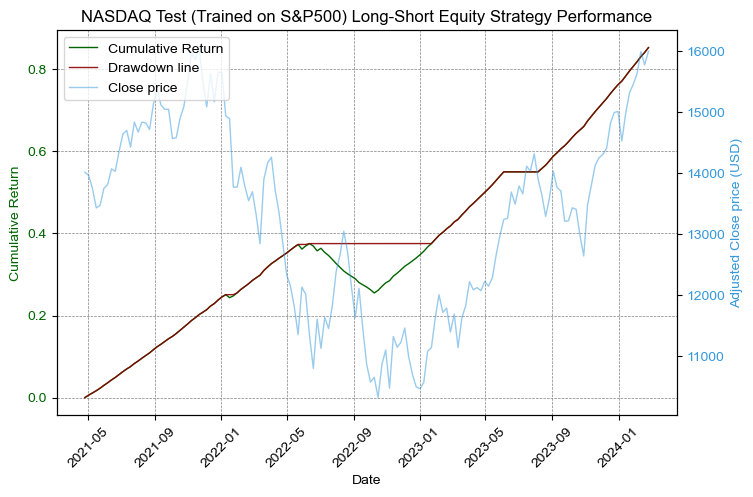

Yearly Returns and Drawdowns:
────────────────────────────────────────
Cumulative return over the period: 34.0 %
Baseline Return (Buy and Hold over the period): -4.7 %
Start Date: 2021-04-25
End Date: 2022-04-17
Maximum drawdown during the period: 2 weeks
────────────────────────────────────────
Cumulative return over the period: 10.1 %
Baseline Return (Buy and Hold over the period): -5.6 %
Start Date: 2022-04-24
End Date: 2023-04-16
Maximum drawdown during the period: 31 weeks
────────────────────────────────────────
────────────────────────────────────────────────────────────────────────────────────────────────────
Cross-testing on IBM Test
Cross-Test Accuracy: 45.0 %
────────────────────────────────────────
Cumulative return over the period: 82.6 %
Baseline Return (Buy and Hold over the period): 45.3 %
Maximum Drawdown Duration 11 weeks
────────────────────────────────────────


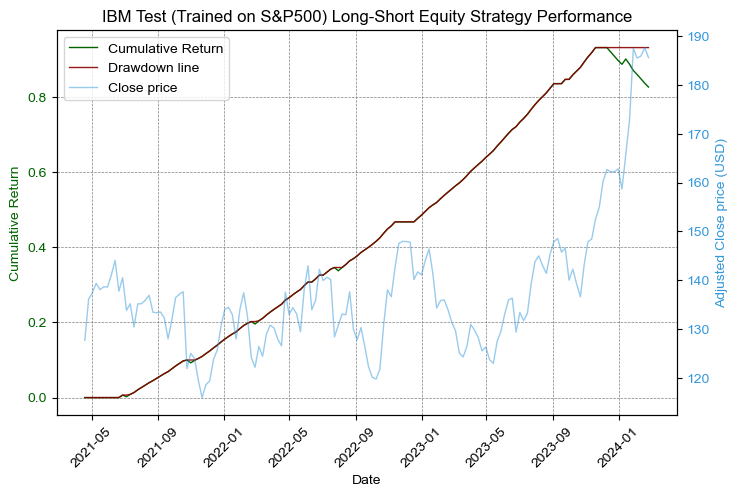

Yearly Returns and Drawdowns:
────────────────────────────────────────
Cumulative return over the period: 24.1 %
Baseline Return (Buy and Hold over the period): 0.2 %
Start Date: 2021-04-18
End Date: 2022-04-10
Maximum drawdown during the period: 2 weeks
────────────────────────────────────────
Cumulative return over the period: 29.1 %
Baseline Return (Buy and Hold over the period): 2.6 %
Start Date: 2022-04-17
End Date: 2023-04-09
Maximum drawdown during the period: 2 weeks
────────────────────────────────────────
────────────────────────────────────────────────────────────────────────────────────────────────────


In [43]:
# Defining and preparing the dataframe subsets to use for cross-testing models
def prepare_test_df(df, name):
    split_idx = int(len(df) * 0.9)
    test_df = df.iloc[split_idx:].drop(columns=['Open', 'High', 'Low']).copy()
    
    # Apply the MinMaxScaler, fitted on the dataset that the model was trained on
    features = test_df[feature_columns]
    scaled_features = scaler.transform(features)
    
    # Store the scaled features back into the DataFrame
    test_df[feature_columns] = scaled_features
    
    return test_df, name

# Prepare each DataFrame
msft_test_df, msft_name = prepare_test_df(msft, 'MSFT Test')
amzn_test_df, amzn_name = prepare_test_df(amzn, 'AMZN Test')
cac_test_df, cac_name = prepare_test_df(cac, 'CAC Test')
nasdaq_test_df, nasdaq_name = prepare_test_df(nasdaq, 'NASDAQ Test')
ibm_test_df, ibm_name = prepare_test_df(ibm, 'IBM Test')

# Create a dictionary for better readability and access
test_dfs = {
    msft_name: msft_test_df,
    amzn_name: amzn_test_df,
    cac_name: cac_test_df,
    nasdaq_name: nasdaq_test_df,
    ibm_name: ibm_test_df
}
    
for df_name, df in test_dfs.items():

    actual_labels_test = df['Next_week_market_behavior']
    
    X_test = df[feature_columns].values
    
    X_test_data = torch.FloatTensor(X_test)  # Convert features to a tensor
    X_test_loader = DataLoader(X_test_data, batch_size=64, shuffle=False)

    predicted_labels_test=experimental.classification_predictions(model, X_test_loader)

    print(f'Cross-testing on {df_name}')
    # Accuracy
    accuracy = accuracy_score(actual_labels_test, predicted_labels_test)
    print(f'Cross-Test Accuracy: {round(accuracy *100, 0)} %')
    print('─' * 40)

    # Returns
    df['Prediction'] = predicted_labels_test

    df=utilities.calculate_returns(df, 'Prediction')
    
    max_drawdown_duration=utilities.calculate_max_drawdown_duration(df)
    
    print(f'Maximum Drawdown Duration {max_drawdown_duration} weeks')
    print('─' * 40) 

    utilities.plot_return(df, df_name+' (Trained on S&P500)', save_figure=True)

    utilities.calculate_yearly_returns(df)

    print('─' * 100)

***
## NASDAQ dataset

### Training for 500 epochs, training size = 1339 cases
epoch    0: Loss=1.15438
epoch   10: Loss=1.03222
epoch   20: Loss=1.01570
epoch   30: Loss=1.00974
epoch   40: Loss=1.00729
epoch   50: Loss=1.00577
epoch   60: Loss=1.00470
epoch   70: Loss=1.00388
epoch   80: Loss=1.00320
epoch   90: Loss=1.00263
epoch  100: Loss=1.00212
epoch  110: Loss=1.00166
epoch  120: Loss=1.00124
epoch  130: Loss=1.00083
epoch  140: Loss=1.00044
epoch  150: Loss=1.00005
epoch  160: Loss=0.99966
epoch  170: Loss=0.99927
epoch  180: Loss=0.99889
epoch  190: Loss=0.99851
epoch  200: Loss=0.99814
epoch  210: Loss=0.99888
epoch  220: Loss=0.99636
epoch  230: Loss=0.99570
epoch  240: Loss=0.99517
epoch  250: Loss=0.99470
epoch  260: Loss=0.99425
epoch  270: Loss=0.99382
epoch  280: Loss=0.99340
epoch  290: Loss=0.99298
epoch  300: Loss=0.99257
epoch  310: Loss=0.99215
epoch  320: Loss=0.99173
epoch  330: Loss=0.99131
epoch  340: Loss=0.99088
epoch  350: Loss=0.99045
epoch  360: Loss=0.99000
epoch  370: Loss=0.

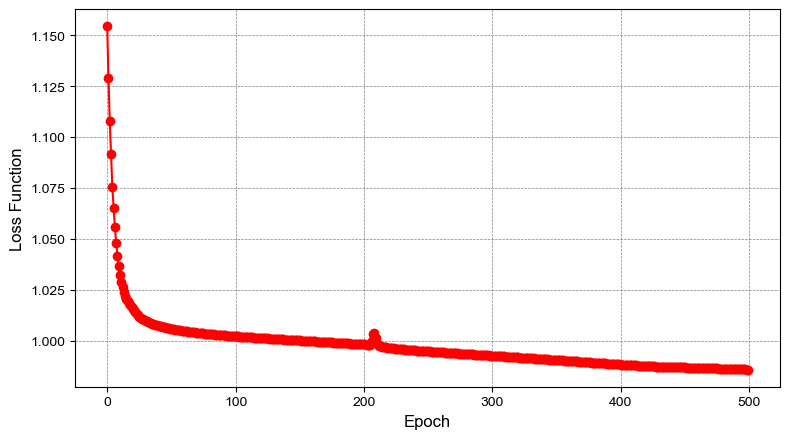

In [44]:
df=nasdaq
    
# Now let's prepare the features
features = df[feature_columns]
scaler = MinMaxScaler()
features = scaler.fit_transform(features)

# Prepare the target to fit the labeling used by pytorch {0,1,2}
target = df['Next_week_market_behavior']+1

# Calculate the index for the split
split_idx = int(len(features) * 0.9)

# Split the features and target into training/testing sets without shuffling
X_train = features[:split_idx]
X_test = features[split_idx:]
y_train = target.iloc[:split_idx]
y_test = target.iloc[split_idx:]

# Convert to PyTorch tensors
train_data = TensorDataset(torch.FloatTensor(X_train), torch.LongTensor(y_train.values))
test_data = TensorDataset(torch.FloatTensor(X_test), torch.LongTensor(y_test.values))

# Create Data Loaders
train_loader = DataLoader(train_data, batch_size=64, shuffle=False)  # Usually, you don't shuffle time series data
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

optimizer = torch.optim.Adam(model.parameters())
experimental.train_anfis_classifier_with(model=model, 
                                         data=train_loader, 
                                         optimizer=optimizer, 
                                         epochs=500, 
                                         show_plots=True)

Training Accuracy: 51.0 %
────────────────────────────────────────


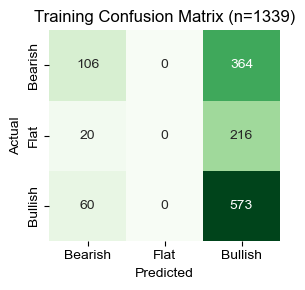

In [45]:
X_train_data = torch.FloatTensor(X_train)  # Convert features to a tensor
X_train_loader = DataLoader(X_train_data, batch_size=64, shuffle=False)
predicted_labels_train =experimental.classification_predictions(model, X_train_loader)

actual_labels_train =y_train-1
# Accuracy
accuracy = accuracy_score(actual_labels_train, predicted_labels_train)
print(f'Training Accuracy: {round(accuracy *100, 0)} %')
print('─' * 40)

# Confusion Matrix
train_conf_matrix = confusion_matrix(actual_labels_train, predicted_labels_train)

plt.figure(figsize=(3,3))
sns.heatmap(train_conf_matrix, annot=True, cmap='Greens', cbar=False, xticklabels=['Bearish', 'Flat', 'Bullish'], yticklabels=['Bearish', 'Flat', 'Bullish'], fmt='d')

plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.title(f'Training Confusion Matrix (n={len(X_train)})')

plt.tight_layout()
#plt.savefig('training_confusion_matrix.png', transparent=True, dpi=300)
plt.show()

Validation Accuracy: 46.0 %
────────────────────────────────────────


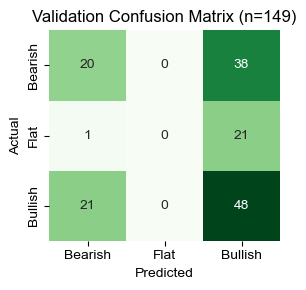

In [46]:
X_test_data = torch.FloatTensor(X_test)  # Convert features to a tensor
X_test_loader = DataLoader(X_test_data, batch_size=64, shuffle=False)
predicted_labels_test=experimental.classification_predictions(model, X_test_loader)

actual_labels_test=y_test-1
# Accuracy
accuracy = accuracy_score(actual_labels_test, predicted_labels_test)
print(f'Validation Accuracy: {round(accuracy *100, 0)} %')
print('─' * 40)

# Confusion Matrix
test_conf_matrix = confusion_matrix(actual_labels_test, predicted_labels_test)

plt.figure(figsize=(3,3))
sns.heatmap(test_conf_matrix, annot=True, cmap='Greens', cbar=False, xticklabels=['Bearish', 'Flat', 'Bullish'], yticklabels=['Bearish', 'Flat', 'Bullish'], fmt='d')

plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.title(f'Validation Confusion Matrix (n={len(X_test)})')

plt.tight_layout()
#plt.savefig('test_confusion_matrix.png', transparent=True, dpi=300)
plt.show()

Cumulative return over the period: 43545.7 %
Baseline Return (Buy and Hold over the period): 1468.4 %
Maximum Drawdown Duration 202 weeks


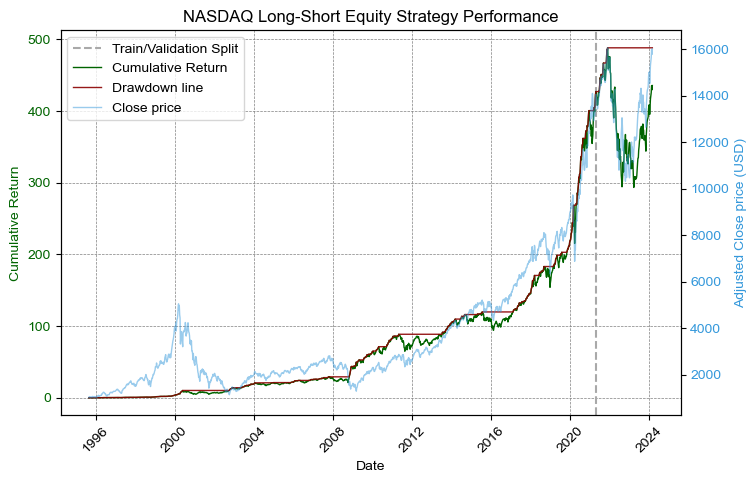

In [47]:
# Combine predictions into a single column
df['Prediction'] = np.concatenate([predicted_labels_train, predicted_labels_test])

df=utilities.calculate_returns(df, 'Prediction')

max_drawdown_duration=utilities.calculate_max_drawdown_duration(amzn)

print(f'Maximum Drawdown Duration {max_drawdown_duration} weeks')

utilities.plot_return(df, 'NASDAQ', train_test_split=0.9, save_figure=True)

Cumulative return over the period: 2.2 %
Baseline Return (Buy and Hold over the period): 14.1 %
Validation Set Maximum Drawdown: 118 weeks


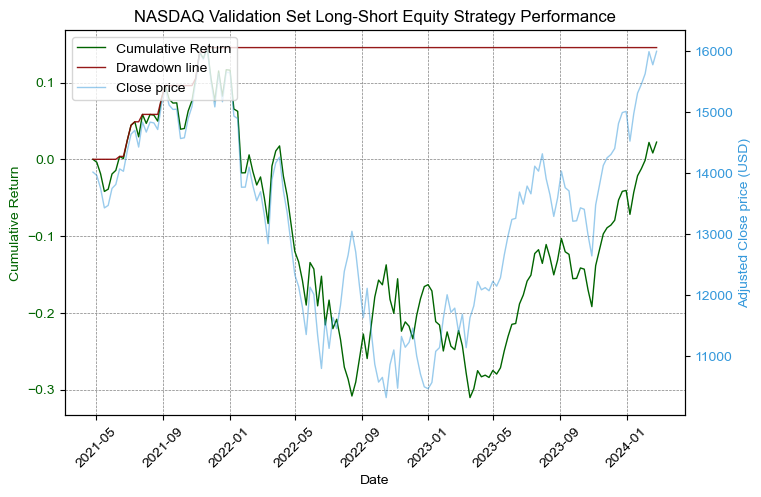

Yearly Returns and Drawdowns:
────────────────────────────────────────
Cumulative return over the period: -4.7 %
Baseline Return (Buy and Hold over the period): -4.7 %
Start Date: 2021-04-25
End Date: 2022-04-17
Maximum drawdown during the period: 21 weeks
────────────────────────────────────────
Cumulative return over the period: -21.5 %
Baseline Return (Buy and Hold over the period): -5.6 %
Start Date: 2022-04-24
End Date: 2023-04-16
Maximum drawdown during the period: 51 weeks
────────────────────────────────────────


In [48]:
split_idx=int(len(nasdaq)*0.9)
nasdaq_test_df=nasdaq[split_idx:]
nasdaq_test_df = utilities.calculate_returns(nasdaq_test_df, 'Prediction')
max_drawdown_duration_test = utilities.calculate_max_drawdown_duration(nasdaq_test_df)
print(f'Validation Set Maximum Drawdown: {max_drawdown_duration_test} weeks')
utilities.plot_return(nasdaq_test_df, 'NASDAQ Validation Set', save_figure=True)
utilities.calculate_yearly_returns(nasdaq_test_df)

Cross-testing on MSFT Test
Cross-Test Accuracy: 44.0 %
────────────────────────────────────────
Cumulative return over the period: 28.2 %
Baseline Return (Buy and Hold over the period): 57.2 %
Maximum Drawdown Duration 58 weeks
────────────────────────────────────────


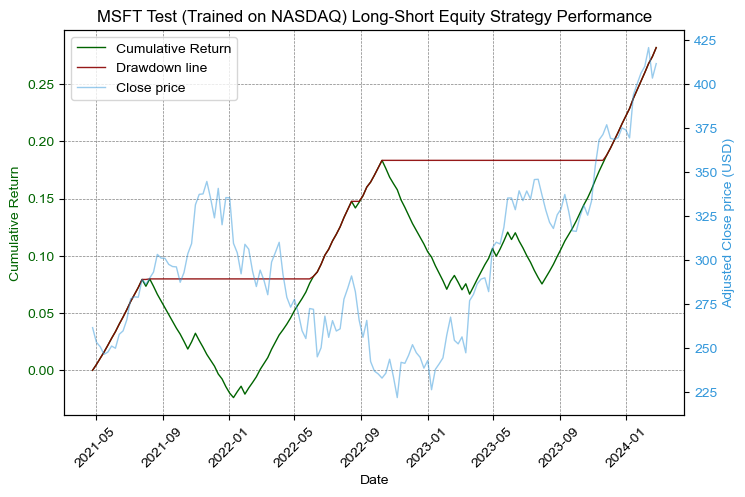

Yearly Returns and Drawdowns:
────────────────────────────────────────
Cumulative return over the period: 4.0 %
Baseline Return (Buy and Hold over the period): 6.6 %
Start Date: 2021-04-25
End Date: 2022-04-17
Maximum drawdown during the period: 36 weeks
────────────────────────────────────────
Cumulative return over the period: 4.4 %
Baseline Return (Buy and Hold over the period): 6.1 %
Start Date: 2022-04-24
End Date: 2023-04-16
Maximum drawdown during the period: 27 weeks
────────────────────────────────────────
────────────────────────────────────────────────────────────────────────────────────────────────────
Cross-testing on AMZN Test
Cross-Test Accuracy: 49.0 %
────────────────────────────────────────
Cumulative return over the period: 19.0 %
Baseline Return (Buy and Hold over the period): 6.2 %
Maximum Drawdown Duration 90 weeks
────────────────────────────────────────


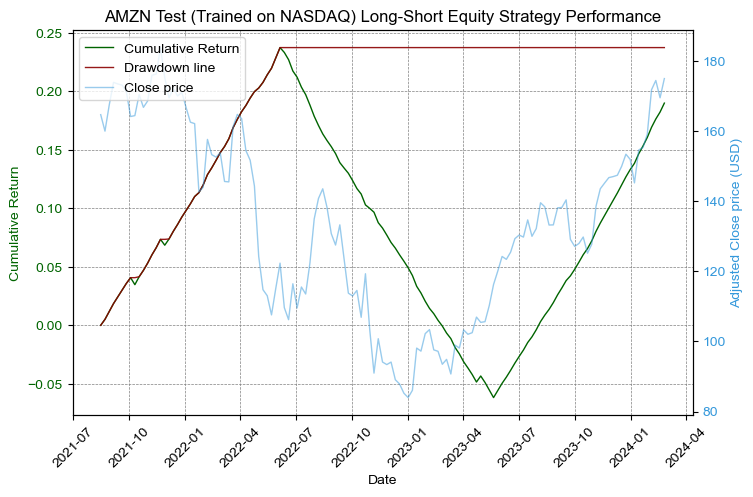

Yearly Returns and Drawdowns:
────────────────────────────────────────
Cumulative return over the period: 17.1 %
Baseline Return (Buy and Hold over the period): -14.5 %
Start Date: 2021-08-15
End Date: 2022-08-07
Maximum drawdown during the period: 9 weeks
────────────────────────────────────────
Cumulative return over the period: -13.8 %
Baseline Return (Buy and Hold over the period): -2.8 %
Start Date: 2022-08-14
End Date: 2023-08-06
Maximum drawdown during the period: 51 weeks
────────────────────────────────────────
────────────────────────────────────────────────────────────────────────────────────────────────────
Cross-testing on CAC Test
Cross-Test Accuracy: 48.0 %
────────────────────────────────────────
Cumulative return over the period: 124.2 %
Baseline Return (Buy and Hold over the period): 27.3 %
Maximum Drawdown Duration 2 weeks
────────────────────────────────────────


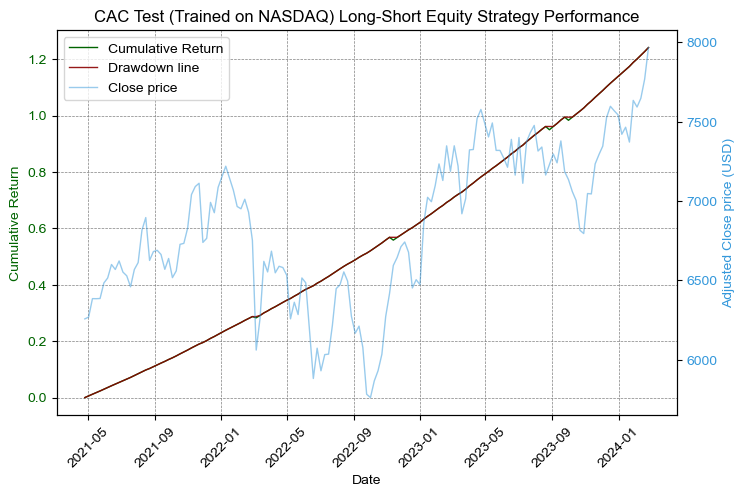

Yearly Returns and Drawdowns:
────────────────────────────────────────
Cumulative return over the period: 33.0 %
Baseline Return (Buy and Hold over the period): 5.3 %
Start Date: 2021-04-25
End Date: 2022-04-17
Maximum drawdown during the period: 1 weeks
────────────────────────────────────────
Cumulative return over the period: 32.5 %
Baseline Return (Buy and Hold over the period): 14.3 %
Start Date: 2022-04-24
End Date: 2023-04-16
Maximum drawdown during the period: 2 weeks
────────────────────────────────────────
────────────────────────────────────────────────────────────────────────────────────────────────────
Cross-testing on S&P500 Test
Cross-Test Accuracy: 44.0 %
────────────────────────────────────────
Cumulative return over the period: 72.8 %
Baseline Return (Buy and Hold over the period): 21.7 %
Maximum Drawdown Duration 34 weeks
────────────────────────────────────────


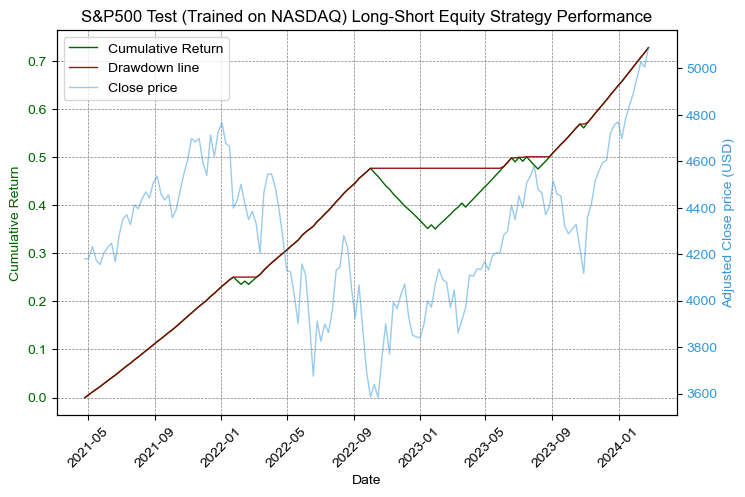

Yearly Returns and Drawdowns:
────────────────────────────────────────
Cumulative return over the period: 29.3 %
Baseline Return (Buy and Hold over the period): 5.1 %
Start Date: 2021-04-25
End Date: 2022-04-17
Maximum drawdown during the period: 6 weeks
────────────────────────────────────────
Cumulative return over the period: 9.3 %
Baseline Return (Buy and Hold over the period): -3.1 %
Start Date: 2022-04-24
End Date: 2023-04-16
Maximum drawdown during the period: 28 weeks
────────────────────────────────────────
────────────────────────────────────────────────────────────────────────────────────────────────────
Cross-testing on IBM Test
Cross-Test Accuracy: 45.0 %
────────────────────────────────────────
Cumulative return over the period: 82.4 %
Baseline Return (Buy and Hold over the period): 45.3 %
Maximum Drawdown Duration 14 weeks
────────────────────────────────────────


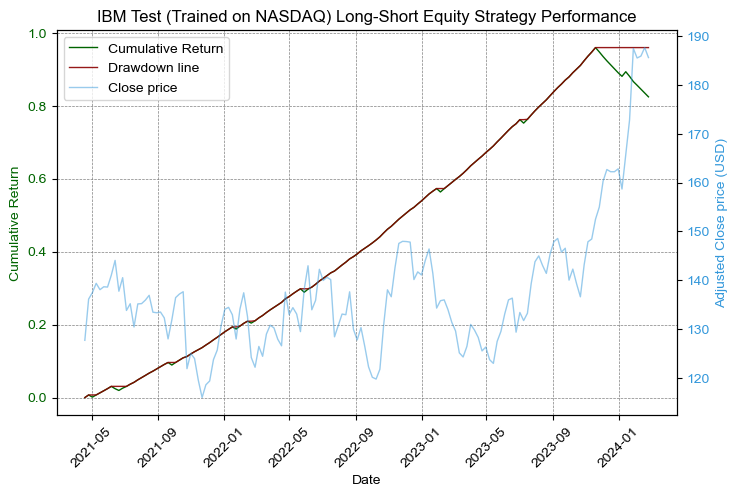

Yearly Returns and Drawdowns:
────────────────────────────────────────
Cumulative return over the period: 25.4 %
Baseline Return (Buy and Hold over the period): 0.2 %
Start Date: 2021-04-18
End Date: 2022-04-10
Maximum drawdown during the period: 4 weeks
────────────────────────────────────────
Cumulative return over the period: 30.4 %
Baseline Return (Buy and Hold over the period): 2.6 %
Start Date: 2022-04-17
End Date: 2023-04-09
Maximum drawdown during the period: 2 weeks
────────────────────────────────────────
────────────────────────────────────────────────────────────────────────────────────────────────────


In [49]:
# Defining and preparing the dataframe subsets to use for cross-testing models
def prepare_test_df(df, name):
    split_idx = int(len(df) * 0.9)
    test_df = df.iloc[split_idx:].drop(columns=['Open', 'High', 'Low']).copy()
    
    # Apply the MinMaxScaler, fitted on the dataset that the model was trained on
    features = test_df[feature_columns]
    scaled_features = scaler.transform(features)
    
    # Store the scaled features back into the DataFrame
    test_df[feature_columns] = scaled_features
    
    return test_df, name

# Prepare each DataFrame
msft_test_df, msft_name = prepare_test_df(msft, 'MSFT Test')
amzn_test_df, amzn_name = prepare_test_df(amzn, 'AMZN Test')
cac_test_df, cac_name = prepare_test_df(cac, 'CAC Test')
sp500_test_df, sp500_name = prepare_test_df(sp500, 'S&P500 Test')
ibm_test_df, ibm_name = prepare_test_df(ibm, 'IBM Test')

# Create a dictionary for better readability and access
test_dfs = {
    msft_name: msft_test_df,
    amzn_name: amzn_test_df,
    cac_name: cac_test_df,
    sp500_name: sp500_test_df,
    ibm_name: ibm_test_df
}
    
for df_name, df in test_dfs.items():

    actual_labels_test = df['Next_week_market_behavior']
    
    X_test = df[feature_columns].values
    
    X_test_data = torch.FloatTensor(X_test)  # Convert features to a tensor
    X_test_loader = DataLoader(X_test_data, batch_size=64, shuffle=False)

    predicted_labels_test=experimental.classification_predictions(model, X_test_loader)

    print(f'Cross-testing on {df_name}')
    # Accuracy
    accuracy = accuracy_score(actual_labels_test, predicted_labels_test)
    print(f'Cross-Test Accuracy: {round(accuracy *100, 0)} %')
    print('─' * 40)

    # Returns
    df['Prediction'] = predicted_labels_test

    df=utilities.calculate_returns(df, 'Prediction')
    
    max_drawdown_duration=utilities.calculate_max_drawdown_duration(df)
    
    print(f'Maximum Drawdown Duration {max_drawdown_duration} weeks')
    print('─' * 40) 

    utilities.plot_return(df, df_name+' (Trained on NASDAQ)', save_figure=True)

    utilities.calculate_yearly_returns(df)

    print('─'*100)